# Restricted N-Body Simulation

In [2]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from matplotlib.animation import FuncAnimation
import pandas as pd
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

%matplotlib qt
plt.rcParams.update(plt.rcParamsDefault)

In [3]:
# Constants
M = 5e12 * const.M_sun.value
SOFTENING = 5e3 * const.pc.value  # Small value to prevent division by zero
HUBBLE_CONST = 68.17975541996692/(const.pc.value*1e3) #Physical value for t = 13.7 and Omega_Lambda = 0.69


class Particle:
    def __init__(self): #initialize 
        r_0 = 0.04e6 * const.pc.value
        phi = np.random.uniform(0,2*np.pi)
        u = np.random.uniform(0,1)
        theta = np.arccos(1-2*u)
        trasnform = [np.sin(theta)* np.cos(phi) ,np.sin(theta)*np.sin(phi),np.cos(theta)]
        self.r = np.array([r_0*a for a in trasnform])
        E_min = -2.66e10 
        E_max = -8e9
        E_0 = np.random.uniform(E_min,E_max) 
        self.E_0 = E_0
        v_tot_init = np.sqrt(2 * (E_0 + const.G.value * M / np.linalg.norm(self.r)))
        self.v = np.array([v_tot_init*a for a in trasnform])
        
    def separation_calc(self):
        return np.sqrt(self.r[0]**2+self.r[1]**2+self.r[2]**2+SOFTENING**2)
    
    def acc_calc(self, H_0, Omega):
        separation = self.separation_calc()
        return -const.G.value*M*self.r/(separation**3) + H_0**2*Omega*self.r

    def update_brute(self, max_timestep,Omega_lambda):
        dt = min(1e-6*max(np.linalg.norm(self.r), SOFTENING)/np.linalg.norm(self.v),max_timestep) #used to be 1e-5, in Jorge's 1e-4
        acc = self.acc_calc(HUBBLE_CONST,Omega_lambda)
        self.v += acc * dt  # Update velocity
        self.r += self.v * dt  # Update position
        #print(self.r /(const.pc.value*10**6))
        #print(self.v)
        return dt
    
    def total_E(self,H_0,Omega):
        separation = self.separation_calc()
        return np.linalg.norm(self.v)**2/2 - const.G.value*M/separation -(H_0**2*Omega*separation**2)/2
     



In [4]:
# Quick Conversions

def s_to_Gyr(t):
    return t/(1e9*365.25*24*3600)
def Gyr_to_s(t):
    return t*(1e9*365.25*24*3600)
def m_to_Mpc(d):
    return d/(const.pc.value*10**6)
def Mpc_to_m(d):
    return d*(const.pc.value*10**6)

In [5]:
def run(max_timestep,Omega_lambda):
    particle = Particle() #Initialize
    t=0 
    xs = []
    ys = []
    zs = []
    distances_list = []
    vxs = []
    vys = []
    vzs = []
    v_tot_list = []
    ts = []
    Es = []
    save_counter = 1
    t_tot = Gyr_to_s(13.7)
    t_save = Gyr_to_s(0.1)
    while t < t_tot: 
        t += particle.update_brute(max_timestep,Omega_lambda)
        #print(t)
        if t > t_save * save_counter: 
            xs.append(particle.r[0])
            ys.append(particle.r[1])
            zs.append(particle.r[2])
            distances_list.append(particle.separation_calc())
            vxs.append(particle.v[0])
            vys.append(particle.v[1])
            vzs.append(particle.v[2])
            ts.append(t)
            v_tot_list.append(np.linalg.norm(particle.v))
            Es.append(particle.total_E(HUBBLE_CONST,0.69))
            save_counter +=1

    #Save last values
    xs.append(particle.r[0])
    ys.append(particle.r[1])
    zs.append(particle.r[2])
    distances_list.append(particle.separation_calc())
    vxs.append(particle.v[0])
    vys.append(particle.v[1])
    vzs.append(particle.v[2])
    ts.append(t)
    v_tot_list.append(np.linalg.norm(particle.v))
    Es.append(particle.total_E(HUBBLE_CONST,0.69))
    return xs,ys,zs,distances_list,vxs,vys,vzs,v_tot_list,Es,particle.E_0
#xs,ys,zs,distances_list,vxs,vys,vzs,v_tot_list,Es,E_0 = run(Gyr_to_s(0.001))

In [6]:
from tqdm import tqdm
def run_simulation(max_timestep,n_particles,Omega_lambda):
    df = pd.DataFrame()
    for i in tqdm(range(n_particles)):
        xs,ys,zs,distances_list,vxs,vys,vzs,v_tot_list,Es,E_0_comp = run(max_timestep,Omega_lambda)
        d = {'x': xs, 'y': ys, 'z': zs, 'distances': distances_list, 'vx': vxs, 'vy': vys, 'vz': vzs, 'velocity':v_tot_list, 'Energy': Es, 'Initial energy': E_0_comp}
        df_new = pd.DataFrame(data= d)
        df = pd.concat([df,df_new])
    return df

In [323]:
df_1particle_test = run_simulation(Gyr_to_s(0.00001),1,0.69) # Used to be 0.001

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:46<00:00, 106.68s/it]


In [142]:
sim_df = pd.read_csv("simulation_data_final.csv")

## Data filtering

In [148]:
from tqdm import tqdm

def filter_data(df):
    # Group by blocks of 138 rows using integer division
    grouped = [df.iloc[i:i+138] for i in range(0, len(df), 138)]
    
    # Keep only complete groups
    valid_particles = [g for g in grouped if len(g) == 138]
    
    return valid_particles

def velocity_comp(valid_particles):
    updated_particles = []
    
    for particle in tqdm(valid_particles):
        dot_product = ((particle["vx"] * particle["x"] + 
                        particle["vy"] * particle["y"] +
                        particle["vz"] * particle["z"]) / particle["distances"])
        
        signs = dot_product / np.abs(dot_product)
        
        # Apply changes directly to the DataFrame
        particle = particle.copy()  # Ensure we modify a new DataFrame
        particle["velocity"] *= signs  # Modify velocity
        particle.reset_index(inplace=True)  # Reset index
        
        updated_particles.append(particle)  # Store the modified DataFrame
    
    return updated_particles

# Process the data
valid_particles = filter_data(sim_df)
valid_particles= velocity_comp(valid_particles)


100%|██████████| 1000/1000 [00:04<00:00, 233.01it/s]


# Energy Conservation

In [234]:
# find the maximum energy ratio difference considering every point
valid_particles_copy = valid_particles.copy()
maximum = 0 
for idx, particle in enumerate(valid_particles_copy):
    particle["Energy ratio"] = particle["Energy"] / particle["Energy"][0]
    particle["Energy ratio difference"] = np.abs(particle["Energy ratio"] - 1)
    if particle["Energy ratio difference"].max() > maximum:
        maximum = particle["Energy ratio difference"].max()
        max_particle = idx
print(maximum, max_particle)

5.827770721844594e-05 87


In [304]:
# Plot energy conservation for a particle in  valid_particles
energy_1 = valid_particles_copy[87]["Energy"]
plt.plot(energy_1/energy_1[0])
plt.xlabel("Time Step")
plt.ylabel("Energy/Initial Energy")
plt.title("Energy over time for Particle 87")
plt.tight_layout()
plt.savefig("Energy_over_time.png")
plt.show()

In [278]:
# Plot the distance for the same particle
distance_1 = valid_particles_copy[87]["distances"]
plt.plot(m_to_Mpc(distance_1))
plt.xlabel("Time Step")
plt.ylabel("Distance[Mpc]")
plt.title("Distance to the perturber over time for a Particle")
#plt.savefig("Distance_over_time.png")

Text(0.5, 1.0, 'Distance to the perturber over time for a Particle')

## Plot the distribution of energy looses 

In [299]:
# Find the maximum energy loss for each particle

max_energy_loss = []
for particle in valid_particles_copy:
    max_energy_loss.append(particle["Energy ratio difference"].max()*100)

# Plot the distribution of maximum energy loss
plt.hist(max_energy_loss, bins=20)
plt.xlabel("Maximum Energy Gain [%]")   
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Energy Gain")
plt.tight_layout()
plt.show()
plt.savefig("Energy_gain_distribution.png")

In [290]:
# Final change
maximum = 0 
for idx, particle in enumerate(valid_particles):
    initial_energy = particle["Energy"].iloc[0]
    final_energy = particle["Energy"].iloc[-1]
    energy_ratio = final_energy / initial_energy
    energy_ratio_difference = 100*(energy_ratio - 1)
    print(energy_ratio_difference)
    if energy_ratio_difference < 0:
        print("negative!")
    if energy_ratio_difference > maximum:
        maximum = energy_ratio_difference
        max_particle = idx

# plot the energy distribution
plt.hist(energy_ratio_difference, bins=40)
plt.xlabel("Maximum Energy Gain [%]")   
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Energy Gain")

0.0032114187233922564
0.0034672595309981347
0.002992358237796644
0.0011482894710423963
0.001148094095793084
0.0011331835463535
0.0030917108229555623
0.0041456643963933
0.0015686834723638299
0.0023909214013961844
0.0016493763388636395
0.0013988193502623147
0.0029716995265438584
0.0011369217735479609
0.0019045248504490075
0.005274144812705828
0.0011327143546235874
0.0011327115985837466
0.0056062264125245065
0.00263450547792754
0.004961965665284396
0.0014211668281305379
0.0011465978378089048
0.0015404069343194493
0.0013457746795841885
0.003957133821197445
0.0019981331729868046
0.0024582971089648353
0.002036067457922286
0.0013481090269440443
0.0012401147714946603
0.0014554546989842265
0.002896436918709
0.0015064017189647672
0.0020598960839501856
0.0014011320334628152
0.00113271225365974
0.0011751444772389874
0.0012234526890697595
0.0030251869512776253
0.0030660430219597856
0.0052865811470015345
0.0012084039067383756
0.001155305000821727
0.001175254809049342
0.002784925133525462
0.003616714

Text(0.5, 1.0, 'Distribution of Maximum Energy Gain')

In [57]:
# Find the maximum distance that a paricle moves away in the last frame
maximum_distance = 0
for particle in valid_particles:
    distance = particle["distances"].iloc[-1]
    if distance > maximum_distance:
        maximum_distance = distance

print(m_to_Mpc(maximum_distance))

2.4052952446719518


## convergence

In [48]:
max_timesteps = Gyr_to_s(np.linspace(1e-7, 0.001, 10))
#print(max_timesteps)
# run the simulation for 3 particles for each max_timestep, and save the median energy loss to plot later
energy_loss = []
for timestep in tqdm(max_timesteps):
    df_1particle_test = run_simulation(timestep, 3,0.69)
    energy_loss_temp = []
    for i in range(0, len(df_1particle_test), 138):  # Assuming each particle has 138 rows
        particle = df_1particle_test.iloc[i:i+138]
        initial_energy = particle["Energy"].iloc[0]
        final_energy = particle["Energy"].iloc[-1]
        energy_ratio = final_energy / initial_energy
        energy_ratio_difference = 100*np.abs(energy_ratio - 1)
        energy_loss_temp.append(energy_ratio_difference)
    energy_loss.append(np.median(energy_loss_temp))


  0%|          | 0/10 [00:00<?, ?it/s]


  0%|          | 0/10 [40:03<?, ?it/s]


KeyboardInterrupt: 

In [308]:
energy_loss_percent = energy_loss

plt.plot(s_to_Gyr(max_timesteps), energy_loss_percent, ".", label="Data")
plt.xlabel("Timestep [Gyr]")
plt.ylabel("Median Energy Loss at the end of the simulation [%]")
plt.title("Energy Loss vs Max Timestep Allowed")
plt.tight_layout()

# Define a quadratic function to fit
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit the curve
x_data = max_timesteps
popt, pcov = curve_fit(quadratic_func, x_data, energy_loss_percent)

# Plot the fitted curve
x_fit = max_timesteps
y_fit = quadratic_func(x_fit, *popt)
plt.plot(s_to_Gyr(x_fit), y_fit, label='Fitted Quadratic Curve', color='red')

plt.legend()
# plt.savefig("Energy_loss_vs_timestep.png")
plt.show()



# Animations

## 2D animation of x and y

In [75]:
# Create figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Set plot limits (adjust based on the range of x and y data in your entire dataset)
all_x = pd.concat([m_to_Mpc(particle_df['x']) for particle_df in valid_particles_physical])
all_y = pd.concat([m_to_Mpc(particle_df['y']) for particle_df in valid_particles_physical])
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())

# Initialize an empty scatter plot for updating later
scatters = ax.scatter([], [], s=10)  # Adjust particle size with 's'

# Animation function to update particle positions
def animate(frame):
    x_data = []
    y_data = []

    # Update the data for each particle at the current frame (timestep)
    for particle_df in valid_particles_physical:
        if frame < len(particle_df):  # Ensure frame is within particle data
            x = particle_df.iloc[frame]['x']
            y = particle_df.iloc[frame]['y']
            x_data.append(m_to_Mpc(x))
            y_data.append(m_to_Mpc(y))

    # Plot updated positions of valid_particles
    scatters.set_offsets(np.c_[x_data, y_data])
    
    # Add labels, titles, or grid if needed (optional)
    ax.set_xlabel('X Position [Mpc]', fontsize=14)
    ax.set_ylabel('Y Position [Mpc]', fontsize=14)
    ax.set_title(f't = {frame/10} Gyr', fontsize=14)
    ax.grid(True)

# Set up the animation
anim = FuncAnimation(fig, animate, frames=138, interval=100)

# Show the animation
plt.show()
#anim.save('2D_animation.mp4',  writer='ffmpeg', fps=5)

## 3D animation of positions

In [378]:
def get_color(velocity):
    return 'red' if velocity > 0 else 'blue'

# Create figure and axis for 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set plot limits based on the range of x, y, and z data across all particles
all_x = pd.concat([m_to_Mpc(particle_df['x']) for particle_df in valid_particles])
all_y = pd.concat([m_to_Mpc(particle_df['y']) for particle_df in valid_particles])
all_z = pd.concat([m_to_Mpc(particle_df['z']) for particle_df in valid_particles])
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())
ax.set_zlim(all_z.min(), all_z.max())

# Animation function to update particle positions in 3D
def animate(frame):
    x_data = []
    y_data = []
    z_data = []
    colors = []

    # Update the data for each particle at the current frame (timestep)
    for particle_df in valid_particles:
        if frame < len(particle_df):  # Ensure frame is within particle data
            x = m_to_Mpc(particle_df.iloc[frame]['x'])
            y = m_to_Mpc(particle_df.iloc[frame]['y'])
            z = m_to_Mpc(particle_df.iloc[frame]['z'])
            velocity = particle_df.iloc[frame]['velocity']
            x_data.append(x)
            y_data.append(y)
            z_data.append(z)
            colors.append(get_color(velocity))

    # Clear the previous scatter plot
    ax.cla()

    # Reset the axis limits
    ax.set_xlim(all_x.min(), all_x.max())
    ax.set_ylim(all_y.min(), all_y.max())
    ax.set_zlim(all_z.min(), all_z.max())

    # Plot updated positions of particles in 3D, recreating the scatter plot
    ax.scatter(x_data, y_data, z_data, c=colors, s=10)  # Use 'c' for color array

    # Set labels and title (optional)
    ax.set_xlabel('X Position[Mpc]', fontsize=14)
    ax.set_ylabel('Y Position[Mpc]', fontsize=14)
    ax.set_zlabel('Z Position[Mpc]', fontsize=14)
    ax.set_title(f't = {frame/10} Gyr', fontsize=14)

# Set up the animation
anim = FuncAnimation(fig, animate, frames=138, interval=10)

# Show the animation
#plt.show()
#save the animation
#anim.save('3D_animation_2.gif', writer='imagemagick', fps=10)
anim.save('3D_animation.mp4', writer='ffmpeg', fps=5)


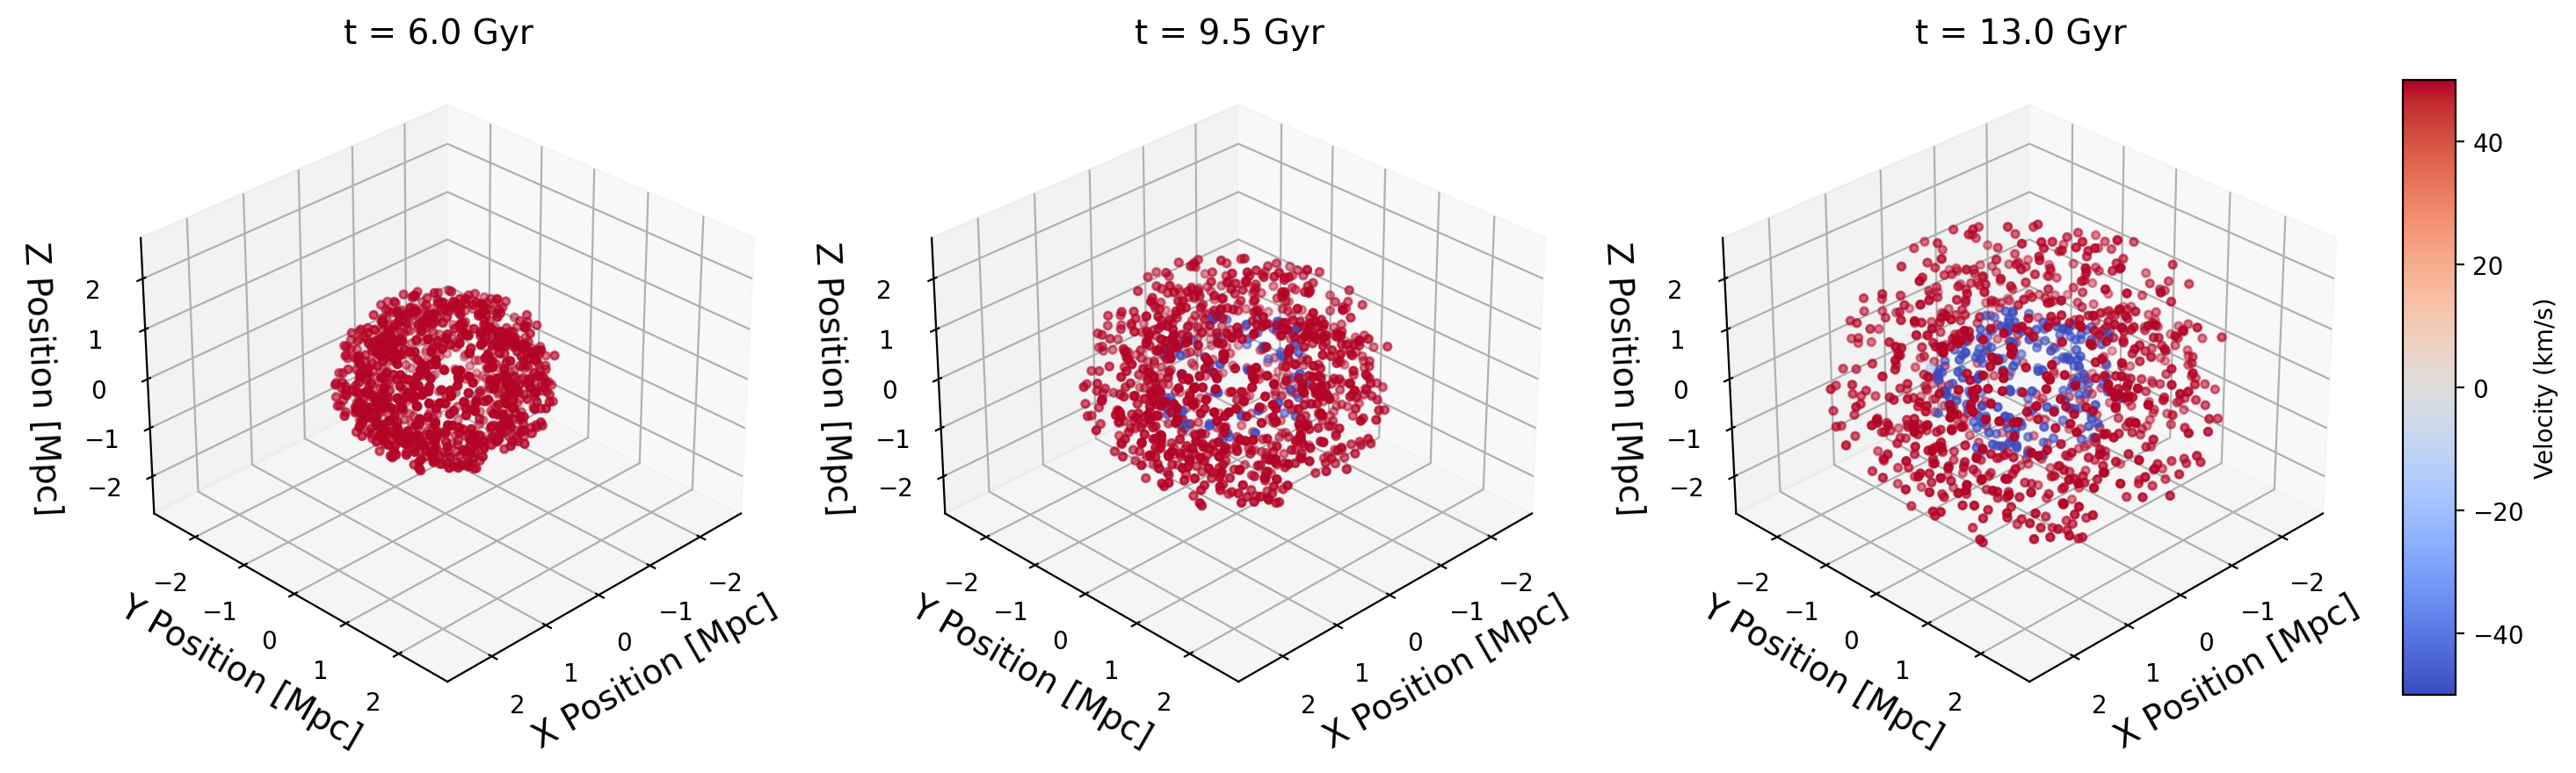

In [161]:

def create_3d_position_snapshots(valid_particles, timesteps=[40, 85, 130], figsize=(15, 5)):
    """
    Create side-by-side 3D position visualizations
    """
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # Get ranges for consistent axes
    all_x = pd.concat([m_to_Mpc(particle_df['x']) for particle_df in valid_particles])
    all_y = pd.concat([m_to_Mpc(particle_df['y']) for particle_df in valid_particles])
    all_z = pd.concat([m_to_Mpc(particle_df['z']) for particle_df in valid_particles])
    
    # Function to get color based on velocity
    def get_color(velocity):
        norm = plt.Normalize(-50, 50)
        return plt.cm.coolwarm(norm(velocity))
    
    # Create each subplot
    axes = []
    for i, timestep in enumerate(timesteps):
        ax = fig.add_subplot(1, len(timesteps), i+1, projection='3d')
        axes.append(ax)
        
        x_data = []
        y_data = []
        z_data = []
        colors = []
        
        # Gather data for this timestep
        for particle_df in valid_particles:
            if timestep < len(particle_df):
                x = m_to_Mpc(particle_df.iloc[timestep]['x'])
                y = m_to_Mpc(particle_df.iloc[timestep]['y'])
                z = m_to_Mpc(particle_df.iloc[timestep]['z'])
                velocity = particle_df.iloc[timestep]['velocity']
                x_data.append(x)
                y_data.append(y)
                z_data.append(z)
                colors.append(get_color(velocity))
        
        # Plot data
        ax.scatter(x_data, y_data, z_data, c=colors, s=10)
        
        # Set consistent axes limits
        ax.set_xlim(all_x.min(), all_x.max())
        ax.set_ylim(all_y.min(), all_y.max())
        ax.set_zlim(all_z.min(), all_z.max())
        
        # Labels and title
        ax.set_xlabel('X Position [Mpc]', fontsize=14)
        ax.set_ylabel('Y Position [Mpc]', fontsize=14)
        ax.set_zlabel('Z Position [Mpc]', fontsize=14)
        ax.set_title(f't = {timestep/10} Gyr', fontsize=14)
        
        # Set viewing angle for consistency
        ax.view_init(elev=30, azim=45)
    
    # Add colorbar for velocity
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-50, 50), cmap=plt.cm.coolwarm), 
                        cax=cbar_ax)
    cbar.set_label('Velocity (km/s)')
    
    # Fix layout
    plt.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9, wspace=0.2)
    
    # Save figure
    plt.savefig('3d_position_snapshots.pdf', format='pdf')
    
    return fig

# Example usage
create_3d_position_snapshots(valid_particles, timesteps=[60, 95, 130])

## 2D animation of vr vs r

In [135]:
# Create figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Assuming 'valid_particles' is a list of DataFrames with the required columns
# Set plot limits based on the range of distances and velocities in the entire dataset
all_distances = pd.concat([m_to_Mpc(particle_df['distances']) for particle_df in valid_particles])
all_velocity = pd.concat([(particle_df['velocity'])/1000 for particle_df in valid_particles])
ax.set_xlim(all_distances.min() - 1, all_distances.max() + 1)
ax.set_ylim(all_velocity.min() - 1, all_velocity.max() + 1)

# Initialize an empty scatter plot for updating later
scatters = ax.scatter([], [], s=10)  # Adjust particle size with 's'

# Animation function to update particle positions
def animate(frame):
    distances_data = []
    velocity_data = []

    # Update the data for each valid particle at the current frame (timestep)
    for particle_df in valid_particles:
        if frame < len(particle_df):  # Ensure frame is within particle data
            distance = particle_df.iloc[frame]['distances']
            velocity = particle_df.iloc[frame]['velocity']
            distances_data.append(m_to_Mpc(distance))
            velocity_data.append(velocity/1000)

    # Plot updated positions of particles
    scatters.set_offsets(np.c_[distances_data, velocity_data])

    # Add labels, titles, or grid if needed (optional)
    ax.set_xlabel('Distance [Mpc]', fontsize=14)
    ax.set_ylabel('Velocity [km/s]', fontsize=14)
    ax.set_title(f't = {frame/10} Gyr', fontsize=14)
    ax.grid(True)

# Set up the animation
anim = FuncAnimation(fig, animate, frames=138, interval=100)

# Show the animation
plt.show()
#anim.save('vr_vs_r.mp4', writer='ffmpeg', fps=10)

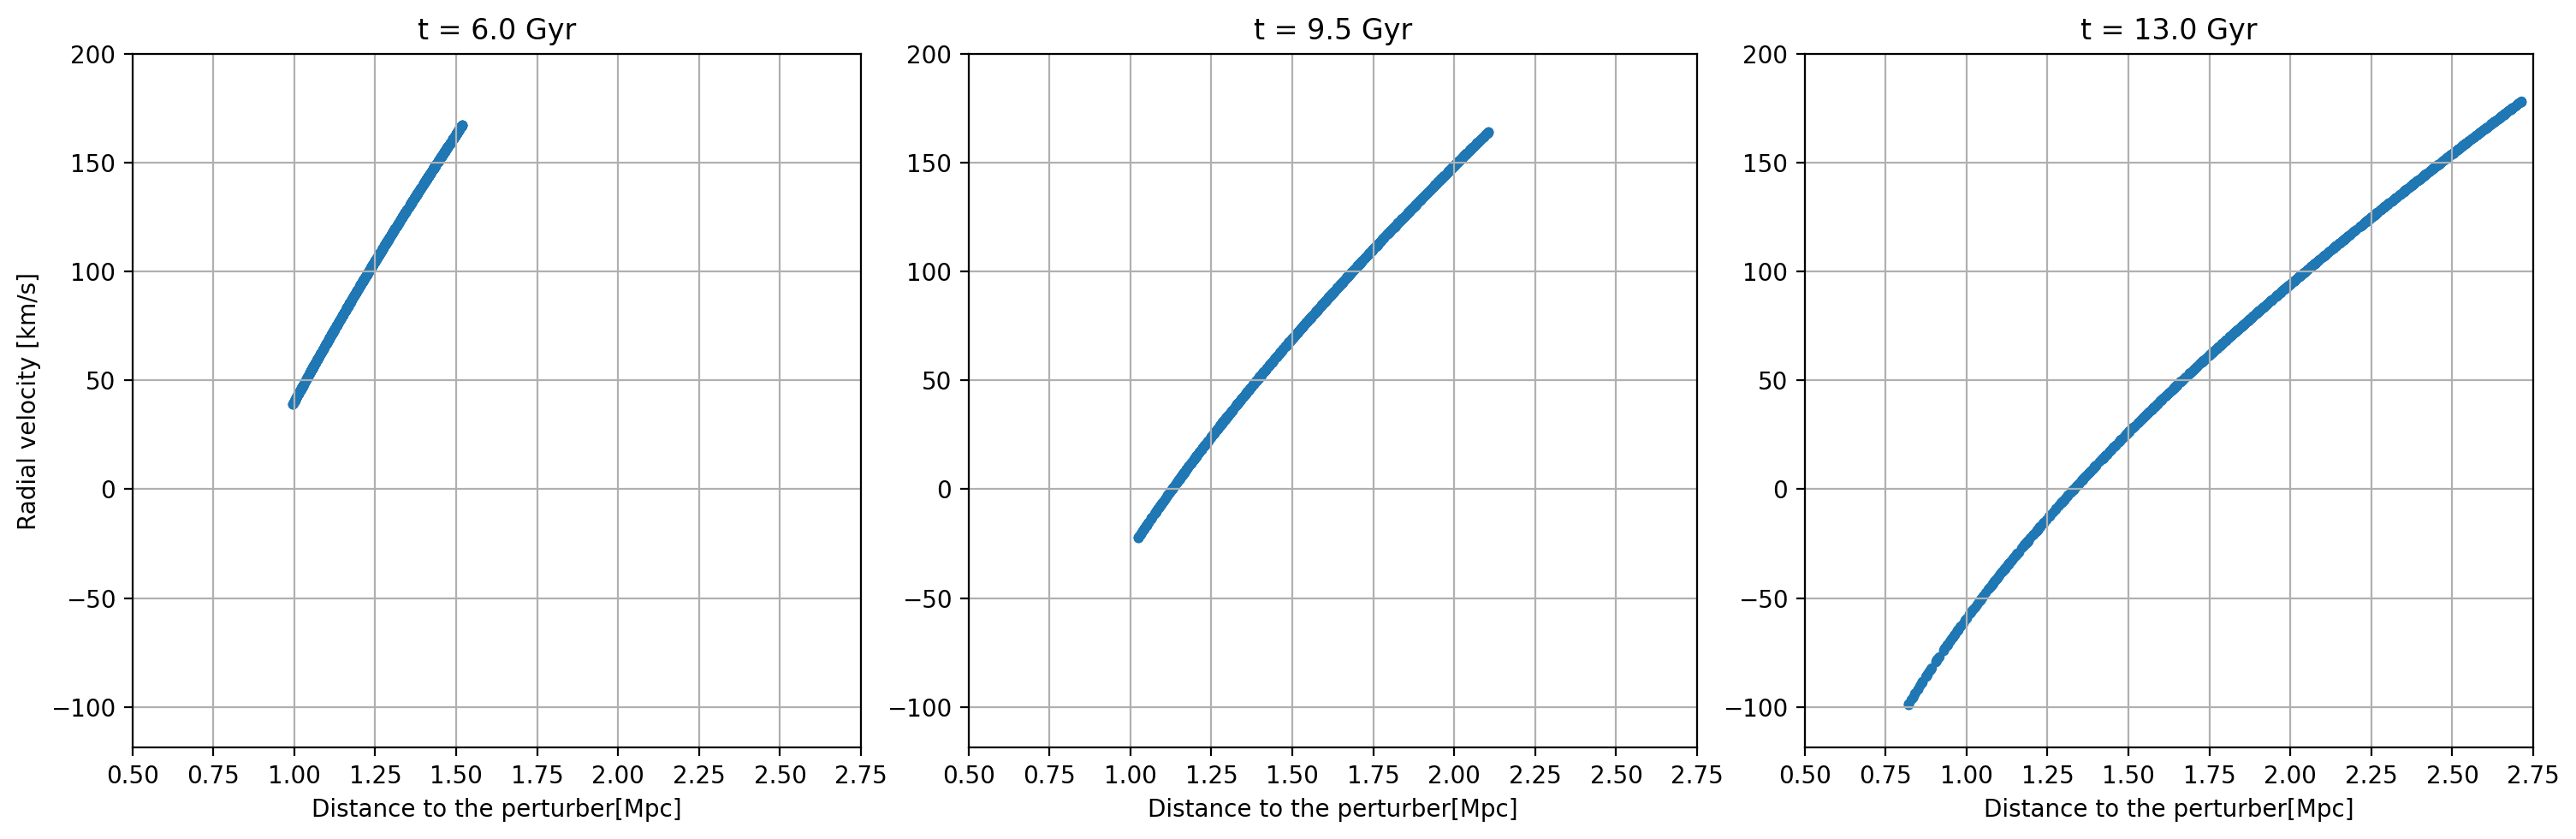

In [168]:
def create_velocity_distance_snapshots(valid_particles, timesteps=[40, 85, 130], figsize=(15, 5)):
    """
    Create side-by-side velocity vs distance visualizations
    """
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(timesteps), figsize=figsize)
    
    # Get ranges for consistent axes
    all_distances = pd.concat([m_to_Mpc(particle_df['distances']) for particle_df in valid_particles])
    all_velocity = pd.concat([(particle_df['velocity'])/1000 for particle_df in valid_particles])
    x_min, x_max = all_distances.min() - 0.2, all_distances.max() + 1
    y_min, y_max = all_velocity.min() - 0.2, all_velocity.max() + 1
    
    # Create each subplot
    for i, timestep in enumerate(timesteps):
        ax = axes[i]
        
        distances_data = []
        velocity_data = []
        
        # Gather data for this timestep
        for particle_df in valid_particles:
            if timestep < len(particle_df):
                distance = particle_df.iloc[timestep]['distances']
                velocity = particle_df.iloc[timestep]['velocity']
                distances_data.append(m_to_Mpc(distance))
                velocity_data.append(velocity/1000)
        
        # Plot data
        ax.scatter(distances_data, velocity_data, s=10)
        
        # Set consistent axes limits
        #ax.set_xlim(x_min, x_max)
        #ax.set_ylim(y_min, y_max) #this does not work very well...

        ax.set_xlim(0.5, 2.75) # Hardcode for now...
        ax.set_ylim(y_min, 200)
        
        # Labels and title
        ax.set_xlabel('Distance to the perturber[Mpc]')
        if i == 0:
            ax.set_ylabel('Radial velocity [km/s]')
        ax.set_title(f't = {timestep/10} Gyr')
        ax.grid(True)
    
    # Fix layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('velocity_distance_snapshots.pdf', format='pdf')
    
    return fig

# Example usage
create_velocity_distance_snapshots(valid_particles, timesteps=[60, 95, 130])

## Projections

In [10]:
d= Mpc_to_m(100) #100 mpc now
# Create the new list of DataFrames with the modified x component
valid_projections = []


for particle_df in valid_particles:
    # Make a copy of the original DataFrame to avoid modifying it directly
    new_particle_df = particle_df.copy()
    
    # Add d to the x component
    new_particle_df['r_primed'] = np.sqrt(new_particle_df['x']**2+ new_particle_df['y']**2 +new_particle_df['z']**2)
    new_particle_df['z'] = new_particle_df['z'] + d
    new_particle_df["distances"] = np.sqrt(new_particle_df['x']**2+ new_particle_df['y']**2 +new_particle_df['z']**2)
    #new_particle_df["theta"] = np.arctan2(new_particle_df["y"],(new_particle_df["x"]))
    #new_particle_df["phi"] = np.arctan2(new_particle_df["z"],(new_particle_df["x"]))
    #new_particle_df["v_los"] = new_particle_df["velocity"]*np.cos(new_particle_df["phi"])*np.cos(new_particle_df["theta"])
    new_particle_df["v_los"] = new_particle_df["vx"]* new_particle_df["x"]/new_particle_df["distances"] + new_particle_df["vy"]* new_particle_df["y"]/new_particle_df["distances"] +new_particle_df["vz"]* new_particle_df["z"]/new_particle_df["distances"]
    
    # Append the modified DataFrame to the valid_projections list
    valid_projections.append(new_particle_df)


## 3d animation of x´, y´and z´

In [124]:
# Create figure and axis for 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set plot limits based on the range of x, y, and z data across all particles
all_x = pd.concat([particle_df['x'] for particle_df in valid_projections])
all_y = pd.concat([particle_df['y'] for particle_df in valid_projections])
all_z = pd.concat([particle_df['z'] for particle_df in valid_projections])
ax.set_xlim(0, all_x.max()) #Force x axis to 0
ax.set_ylim(all_y.min(), all_y.max())
ax.set_zlim(all_z.min(), all_z.max())

# Initialize an empty scatter plot for updating later
scatters = ax.scatter([], [], [], s=10)  # Adjust particle size with 's'

# Animation function to update particle positions in 3D
def animate(frame):
    x_data = []
    y_data = []
    z_data = []
    colors = []
    # Update the data for each particle at the current frame (timestep)
    for particle_df in valid_projections:
        if frame < len(particle_df):  # Ensure frame is within particle data
            x = particle_df.iloc[frame]['x']
            y = particle_df.iloc[frame]['y']
            z = particle_df.iloc[frame]['z']
            velocity = particle_df.iloc[frame]['v_los']
            x_data.append(x)
            y_data.append(y)
            z_data.append(z)
            colors.append(get_color(velocity))

    # Clear the previous scatter plot
    ax.cla()

    
    # Reset the axis limits
    ax.set_xlim(all_x.min(), all_x.max())
    ax.set_ylim(all_y.min(), all_y.max())
    ax.set_zlim(all_z.min(), all_z.max())

    # Plot updated positions of particles in 3D, recreating the scatter plot
    ax.scatter(x_data, y_data, z_data, c=colors, s=10)  # Use 'c' for color array
    
    # Set labels and title (optional)
    ax.set_xlabel('X´ Position')
    ax.set_ylabel('Y´ Position')
    ax.set_zlabel('Z´ Position')
    ax.set_title(f'Timestep {frame}')
    ax.grid(True)

# Set up the animation
anim = FuncAnimation(fig, animate, frames=138, interval=10)

# Show the animation
plt.show()
#anim.save('3D_animation_projection.gif', writer='imagemagick', fps=10)

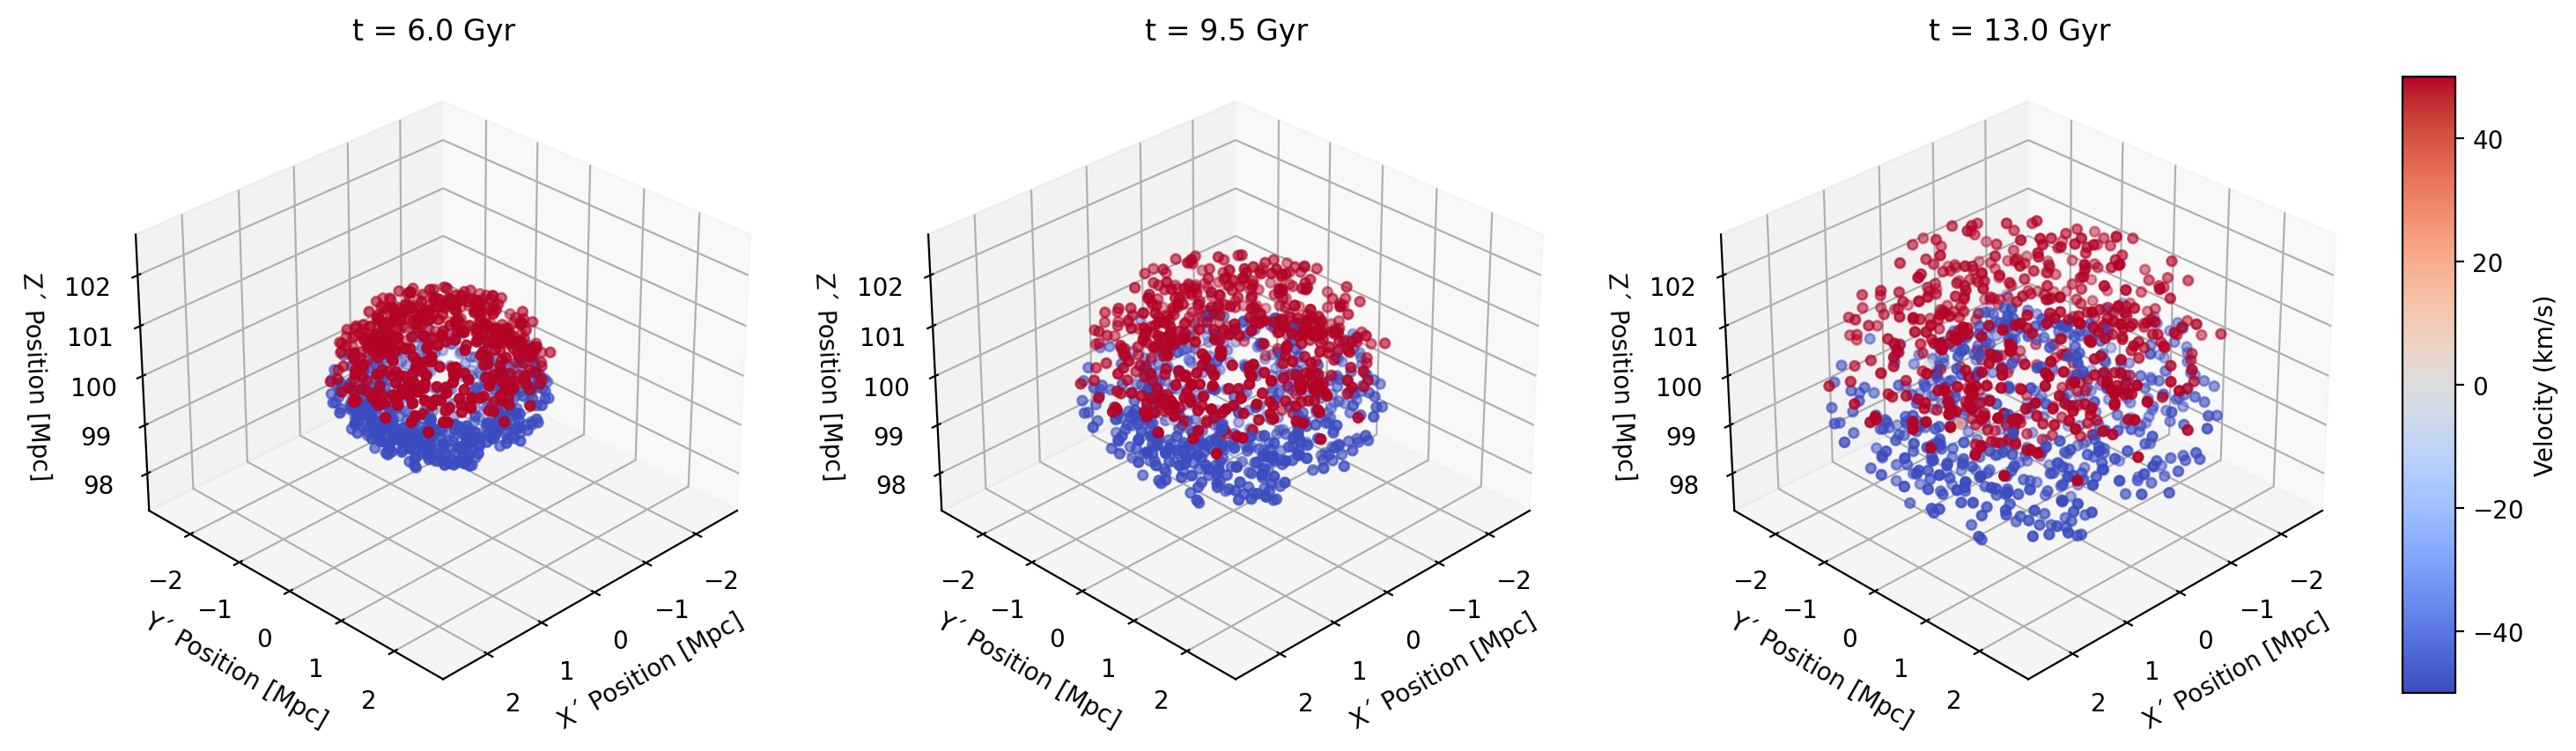

In [163]:
def create_timestep_snapshots(valid_projections, timesteps=[40, 80, 120], figsize=(15, 5)):
    """
    Create side-by-side 3D visualizations with positions in Mpc
    """
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # Convert data to Mpc and get ranges for consistent axes
    all_x_mpc = pd.concat([m_to_Mpc(particle_df['x']) for particle_df in valid_projections])
    all_y_mpc = pd.concat([m_to_Mpc(particle_df['y']) for particle_df in valid_projections])
    all_z_mpc = pd.concat([m_to_Mpc(particle_df['z']) for particle_df in valid_projections])
    
    # Function to get color based on velocity
    def get_color(velocity):
        norm = plt.Normalize(-50, 50)
        return plt.cm.coolwarm(norm(velocity))
    
    # Create each subplot
    axes = []
    for i, timestep in enumerate(timesteps):
        ax = fig.add_subplot(1, len(timesteps), i+1, projection='3d')
        axes.append(ax)
        
        x_data_mpc = []
        y_data_mpc = []
        z_data_mpc = []
        colors = []
        
        # Gather data for this timestep
        for particle_df in valid_projections:
            if timestep < len(particle_df):
                x_mpc = m_to_Mpc(particle_df.iloc[timestep]['x'])
                y_mpc = m_to_Mpc(particle_df.iloc[timestep]['y'])
                z_mpc = m_to_Mpc(particle_df.iloc[timestep]['z'])
                velocity = particle_df.iloc[timestep]['v_los']
                x_data_mpc.append(x_mpc)
                y_data_mpc.append(y_mpc)
                z_data_mpc.append(z_mpc)
                colors.append(get_color(velocity))
        
        # Plot data
        scatter = ax.scatter(x_data_mpc, y_data_mpc, z_data_mpc, c=colors, s=15)
        
        # Set consistent axes limits
        ax.set_xlim(all_x_mpc.min(), all_x_mpc.max())
        ax.set_ylim(all_y_mpc.min(), all_y_mpc.max())
        ax.set_zlim(all_z_mpc.min(), all_z_mpc.max())
        
        # Labels and title - convert timestep to time in Gyr
        time_in_gyr = timestep / 10  # Assuming 1 timestep = 0.1 Gyr
        ax.set_xlabel('X´ Position [Mpc]')
        ax.set_ylabel('Y´ Position [Mpc]')
        ax.set_zlabel('Z´ Position [Mpc]')
        ax.set_title(f't = {time_in_gyr} Gyr')
        
        # Set viewing angle for consistency
        ax.view_init(elev=30, azim=45)
        ax.grid(True)
    
    # Add colorbar for velocity
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-50, 50), cmap=plt.cm.coolwarm), 
                        cax=cbar_ax)
    cbar.set_label('Velocity (km/s)')
    
    # Fix layout issue by using subplots_adjust instead of tight_layout
    plt.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9, wspace=0.2)
    
    # Save figure
    plt.savefig('timestep_snapshots_mpc.png', dpi=300, bbox_inches='tight')
    plt.savefig('timestep_snapshots_mpc.pdf', format='pdf')
    
    return fig

# Example usage
create_timestep_snapshots(valid_projections, timesteps=[60, 95, 130])

## 2D animation of line of sight velocity vs distance

In [396]:
# Create figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Assumingn valid_projections' is a list of DataFrames with the required columns
# Set plot limits based on the range of distances and velocities in the entire dataset
all_distances = pd.concat([m_to_Mpc(particle_df['distances']) for particle_df in valid_projections])
all_velocity = pd.concat([particle_df['v_los']/1000 for particle_df in valid_projections])
ax.set_xlim(all_distances.min() - 1, all_distances.max() + 1)
ax.set_ylim(all_velocity.min() - 1, all_velocity.max() + 1)

# Initialize an empty scatter plot for updating later
scatters = ax.scatter([], [], s=10, alpha=0.5)  # Adjust particle size with 's

# Animation function to update particle positions
def animate(frame):
    #ax.clear()  # Clear the axis for each frame
    distances_data = []
    velocity_data = []

    # Update the data for each valid particle at the current frame (timestep)
    for particle_df in valid_projections:
        if frame < len(particle_df):  # Ensure frame is within particle data
            distance = particle_df.iloc[frame]['distances']
            velocity = particle_df.iloc[frame]['v_los']
            distances_data.append(m_to_Mpc(distance))
            velocity_data.append(velocity/1000)

    # Plot updated positions of particles
    scatters.set_offsets(np.c_[distances_data, velocity_data])
    

    # Add labels, titles, or grid if needed (optional)
    ax.set_xlabel('Distance to the Observer [Mpc]')
    ax.set_ylabel('Line of Sight Velocity [km/s]')
    ax.set_title(f't = {frame/10} Gyr')
    ax.grid(True)

# Set up the animation
anim = FuncAnimation(fig, animate, frames=138, interval=100)

# Show the animation
#plt.show()
anim.save('v_los.mp4', writer='ffmpeg', fps=10)

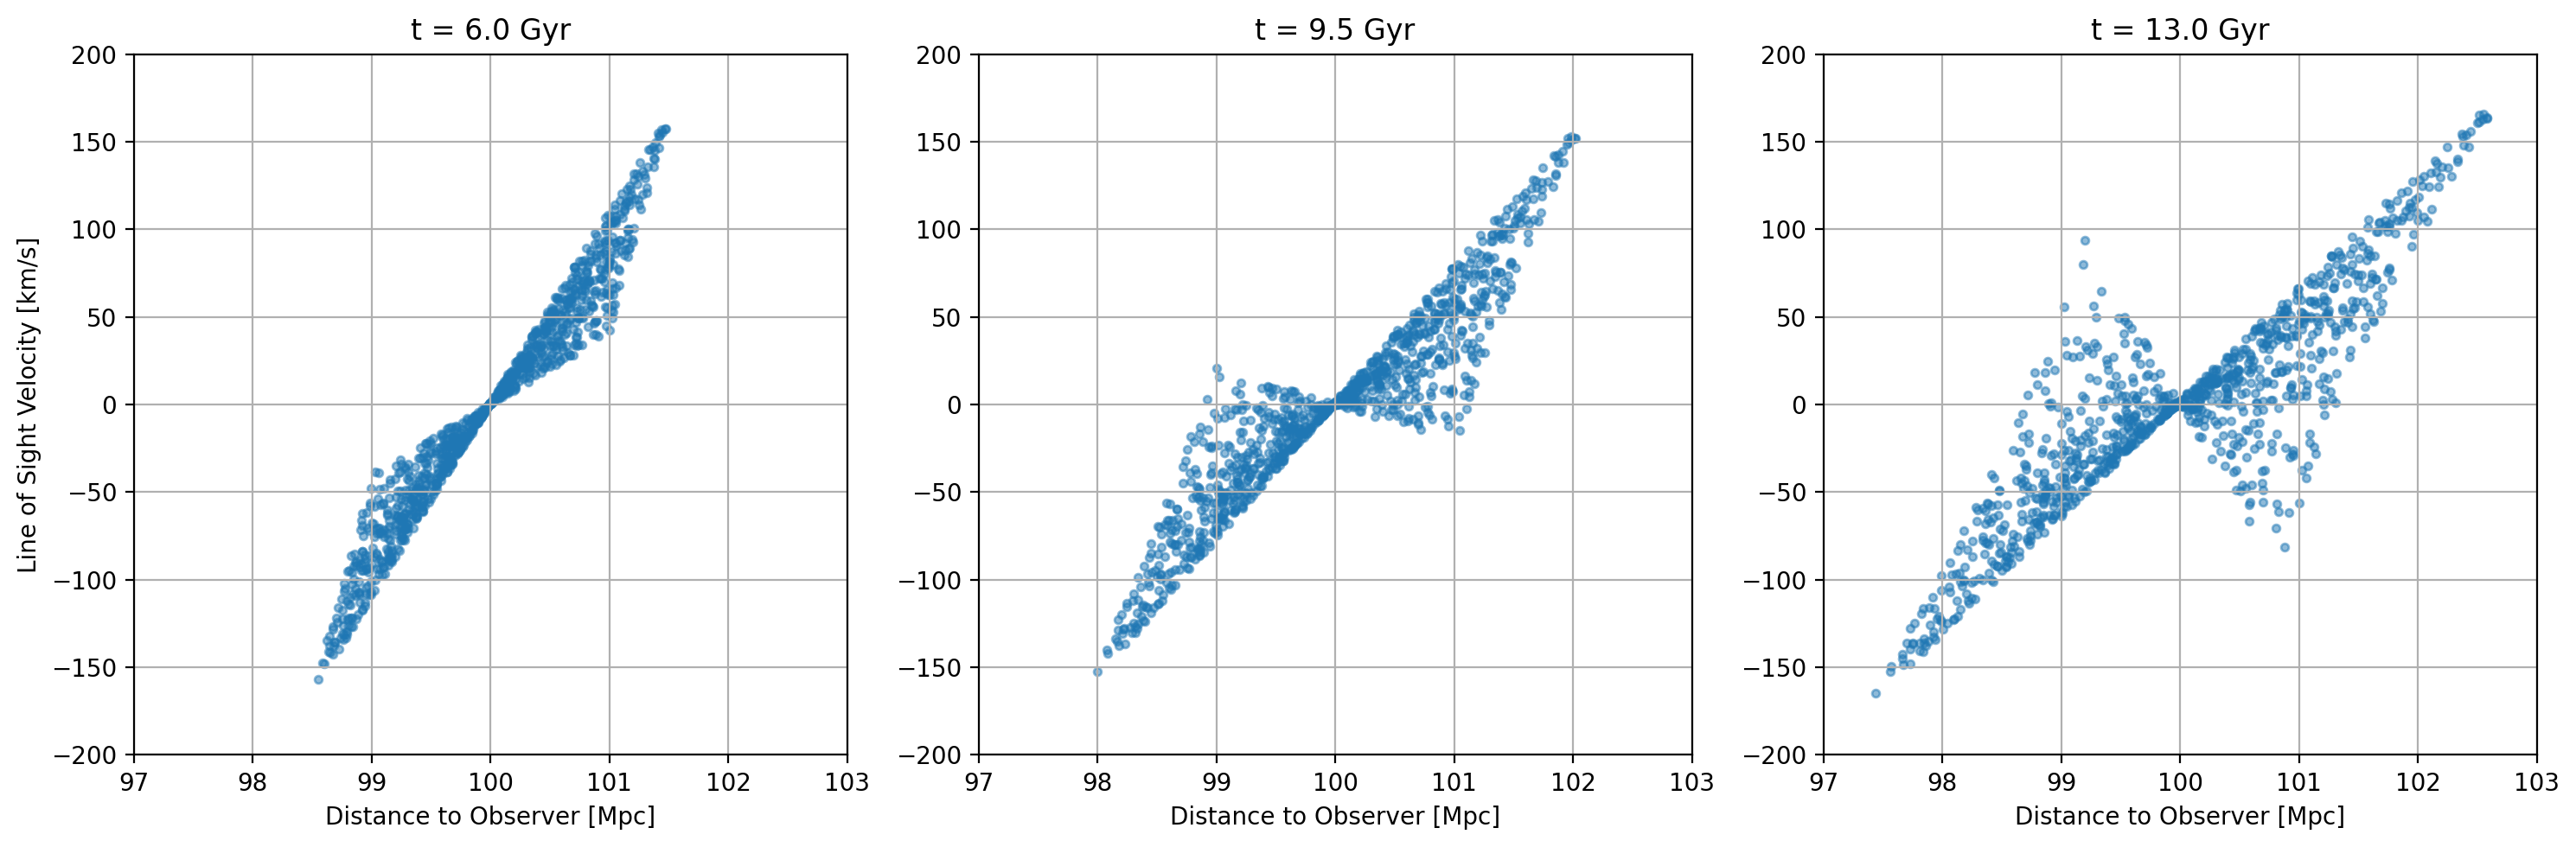

In [175]:
def create_hubble_snapshots(valid_projections, timesteps=[40, 80, 120], figsize=(15, 5)):
    """
    Create side-by-side Hubble diagram visualizations
    """
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(timesteps), figsize=figsize)
    
    # Get ranges for consistent axes
    all_distances = pd.concat([m_to_Mpc(particle_df['distances']) for particle_df in valid_projections])
    all_velocity = pd.concat([particle_df['v_los']/1000 for particle_df in valid_projections])
    x_min, x_max = all_distances.min() - 1, all_distances.max() + 1
    y_min, y_max = all_velocity.min() - 1, all_velocity.max() + 1
    
    # Create each subplot
    for i, timestep in enumerate(timesteps):
        ax = axes[i]
        
        distances_data = []
        velocity_data = []
        
        # Gather data for this timestep
        for particle_df in valid_projections:
            if timestep < len(particle_df):
                distance = particle_df.iloc[timestep]['distances']
                velocity = particle_df.iloc[timestep]['v_los']
                distances_data.append(m_to_Mpc(distance))
                velocity_data.append(velocity/1000)
        
        # Plot data
        ax.scatter(distances_data, velocity_data, s=10, alpha=0.5)
        
        # Set consistent axes limits
        ax.set_xlim(97, 103)
        ax.set_ylim(-200, 200)
        
        # Labels and title
        ax.set_xlabel('Distance to Observer [Mpc]')
        ax.set_ylabel('Line of Sight Velocity [km/s]') if i == 0 else None
        ax.set_title(f't = {timestep/10} Gyr')
        ax.grid(True)
    
    # Fix layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('hubble_snapshots.pdf', format='pdf')
    
    return fig

# Example usage
create_hubble_snapshots(valid_projections, timesteps=[60, 95, 130])

## Final snapshot

In [11]:
from tqdm import tqdm
df_final_snapshot = pd.DataFrame()
for i in tqdm(range(len(valid_projections))):
    df_new = valid_projections[i].iloc[-1].to_frame().T  # Convert Series to DataFrame and transpose to make it a row
    df_final_snapshot = pd.concat([df_final_snapshot, df_new], ignore_index=True)
#df_final_snapshot.drop('Unnamed: 0', axis=1, inplace=True) 
df_final_snapshot['theta'] = np.arccos(df_final_snapshot['z']/df_final_snapshot['distances'])
#df_final_snapshot.drop('Unnamed: 0', axis=1, inplace=True)

100%|██████████| 1000/1000 [00:01<00:00, 717.70it/s]


In [12]:
# convert x,y,z,distances to Mpc
df_final_snapshot['x'] = m_to_Mpc(df_final_snapshot['x'])
df_final_snapshot['y'] = m_to_Mpc(df_final_snapshot['y'])
df_final_snapshot['z'] = m_to_Mpc(df_final_snapshot['z'])
df_final_snapshot['distances'] = m_to_Mpc(df_final_snapshot['distances'])
df_final_snapshot['r_primed'] = m_to_Mpc(df_final_snapshot['r_primed'])
#convert vx,vy,vz, velocity, v_los to km/s
df_final_snapshot['vx'] = df_final_snapshot['vx']/1000
df_final_snapshot['vy'] = df_final_snapshot['vy']/1000
df_final_snapshot['vz'] = df_final_snapshot['vz']/1000
df_final_snapshot['velocity'] = df_final_snapshot['velocity']/1000
df_final_snapshot['v_los'] = df_final_snapshot['v_los']/1000
df_final_snapshot.drop('index', axis=1, inplace=True)

In [244]:
df_final_snapshot.to_csv('final_snapshot_units.csv',index=False)

In [7]:
df_final_snapshot = pd.read_csv("final_snapshot_units.csv")

## Randomize Data

In [8]:
def randomize_data(df_final_snapshot):
    mock_data_df = pd.DataFrame()
    mock_data_df["s"] = df_final_snapshot["distances"]
    mock_data_df["v_los"] = df_final_snapshot["v_los"]
    mock_data_df["theta"] = np.arccos(df_final_snapshot['z']/df_final_snapshot['distances'])
    columns_to_randomize = ['s', "v_los"]  
    # 100kpc in D and 20 km/s in v_los
    mock_data_df["s_error"] = 0.1
    mock_data_df["v_los_error"] = np.sqrt(20**2 + 50**2)

    # randomize the data with the errors
    for column in columns_to_randomize:
        mean_values = mock_data_df[column]
        std_dev = mock_data_df[column + '_error']
        mock_data_df[column] = np.random.normal(loc=mean_values, scale=std_dev, size=len(mock_data_df))
    mock_data_df["v_los_error"] = 20
    return mock_data_df

#mock_data_df = randomize_data(df_final_snapshot)
mock_data_df = randomize_data(df_final_snapshot)

In [23]:
# Plot distances vs v_los for the mock data and the final snapshot
plt.figure(figsize=(10, 6))
plt.plot(mock_data_df["s"],mock_data_df["v_los"],".",label = "Mock Data")
plt.plot((df_final_snapshot["distances"]),df_final_snapshot["v_los"],".", label = "Simulation Data")
plt.xlabel("Distance from the Observer [Mpc]")
plt.ylabel("Line of Sight Velocity [km/s]")
plt.legend()
#plt.title("Mock Data vs True Data")
plt.tight_layout()
plt.show()
plt.savefig("Mock_vs_True.png")

# Bow ties comparison

In [10]:
def v_model(s_primed,theta,t,D,mp,Omega_lambda):
    t = Gyr_to_s(t) # s
    D = Mpc_to_m(D) # m
    s_primed = Mpc_to_m(s_primed) # m
    r_primed = np.sqrt(D**2 + s_primed**2 - 2*D*s_primed*np.cos(theta)) # m 
    term_1 = (r_primed/t)
    term_2 = np.sqrt((const.G.value*mp)/r_primed)
    argument = s_primed * np.sin(theta) / r_primed
    argument = np.clip(argument, -1.0, 1.0) #DISCUSS THIS
    theta_primed = np.arcsin(argument)
    #theta_primed = np.arcsin(s_primed * np.sin(theta) / r_primed)
    expanssion_term = 0.31*Omega_lambda*r_primed/t
    mask = s_primed*np.cos(theta) < D
    theta_primed[mask] = np.pi - theta_primed[mask]
    term_3 = np.cos(theta_primed-theta)
    return (1.2*term_1 - 1.1*term_2+expanssion_term)*term_3 / 1000 #km/s

# Lyndell-Bell
def Lyndell_calc(r_primed,t,mp,Omega_lambda):
    r_primed = Mpc_to_m(r_primed)
    t = Gyr_to_s(t)
    term_1 = (r_primed/t)
    term_2 = np.sqrt((const.G.value*mp)/r_primed)
    expanssion_term = 0.31*Omega_lambda*r_primed/t
    #print(theta_primed,theta,term_1,term_2,term_3)
    return (1.2*term_1 - 1.1*term_2 + expanssion_term) / 1000
def Lyndell_Bell_no_expanssion(r_primed,t,mp):
    r_primed = Mpc_to_m(r_primed)
    t = Gyr_to_s(t)
    term_1 = (r_primed/t)
    term_2 = np.sqrt((const.G.value*mp)/r_primed)
    #print(theta_primed,theta,term_1,term_2,term_3)
    return (1.2*term_1 - 1.1*term_2) / 1000

In [179]:
def compare_Lyndell(r_primed,v,t,mp,Omega_lambda):
    plt.plot(r_primed,v,".",label= "Simulation")
    plt.plot(r_primed,Lyndell_calc(r_primed,t,mp,Omega_lambda),".",label= "Lynden-Bell")
    plt.xlabel('Distance [Mpc]')
    plt.ylabel('Velocity [km/s]')
    #plt.title('Modified Hubble Flow', fontsize=14)
    plt.tight_layout()
    plt.legend()
    plt.show()
compare_Lyndell(df_final_snapshot["r_primed"],df_final_snapshot["velocity"],13.7,M,0.69)
plt.savefig("Lynden_Bell.pdf")

In [183]:
def compare_bow_ties(d,v_los,theta,t,D,M,Omega_lambda):
    plt.plot(d, v_model(d,theta,t,100,M,Omega_lambda), '.', label='Analytical expression')
    plt.plot(d, v_los, '.', label='Simulation')
    #plt.plot(df_final_snapshot['distances_Mpc'], df_final_snapshot['v_los_analytical_wrong'], '.', label='MCMC parameters')
    plt.xlabel('Distance [Mpc]')
    plt.ylabel('Line of Sight Velocity [km/s]')
    plt.legend()
    plt.tight_layout()
    #plt.title('Distances vs line of sight velocities')
    plt.show()
#plt.savefig('bow_ties_simulation_presentation.png')
compare_bow_ties(df_final_snapshot['distances'],df_final_snapshot['v_los'],
df_final_snapshot['theta'],13.7,100,M,0.69)
plt.savefig("bow_tie.pdf")


In [40]:
# Define the range of distances in Mpc
r_primed_range = np.linspace(0.01, 4, 1000)

# Define different times in Gyr
times = [2, 6, 13, 50]

# Plot the analytical expression for different times
plt.figure(figsize=(10, 6))
for t in times:
    v_analytical = Lyndell_calc(r_primed_range, t, M,0.69)
    v_no_expansion = Lyndell_Bell_no_expanssion(r_primed_range, t, M)
    plt.plot(r_primed_range, v_analytical, label=f't = {t} Gyr')
    plt.plot(r_primed_range, v_no_expansion, linestyle=':', color=plt.gca().lines[-1].get_color(), alpha=0.5)

# Add a dotted line around y = 0
plt.axhline(y=0, color='black', linestyle='--', label='turnaround radius')

# Add labels, title, and legend
plt.xlabel('Distance [Mpc]')
plt.ylabel('Velocity [km/s]')
#plt.title('Velocity vs Distance for Different Times', fontsize=16)
plt.legend()
plt.ylim(-200, 400)
#plt.title('Velocity vs Distance for Different Times')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("Lyndell_Bell_varying_time.pdf")

In [32]:
# Define the range of distances in Mpc
r_primed_range = np.linspace(0.01, 4, 1000)

# Define different masses in solar masses
masses = [0, 1e12, 5e12, 1e13, 5e13]

# Plot the analytical expression for different masses
plt.figure(figsize=(10, 6))
for i, mass in enumerate(masses):
    mass_in_kg = mass * const.M_sun.value
    v_analytical = Lyndell_calc(r_primed_range, 13.7, mass_in_kg, 0.69)
    
    # Special formatting for M=0 case
    if mass == 0:
        plt.plot(r_primed_range, v_analytical, color='black', linestyle='dashdot', alpha=0.5, 
                 label='Unperturbed Hubble flow')
    else:
        plt.plot(r_primed_range, v_analytical, label=f'M = {mass:.1e} $M_{{\odot}}$')

# Add a dotted line around y = 0
plt.axhline(y=0, color='black', linestyle='--', label='turnaround radius')

# Add labels, title, and legend
plt.xlabel('Distance [Mpc]')
plt.ylabel('Velocity [km/s]')
plt.legend()
plt.ylim(-700, 400)
plt.tight_layout()
plt.show()
plt.savefig("Lyndell_Bell_masses.pdf")

# Likelihood Function - MCMC

In [30]:
from scipy.stats import norm
from scipy.special import logsumexp

# OLD STUFF CHECK UNITS 
def log_prior(phi):
    t, mp, Omega_lambda,hyper = phi
    if 5 < t < 20 and 10 < mp < 16 and 0.5 < Omega_lambda < 1 and hyper > 0:
        return 0.0
    return -np.inf
    
def log_likelihood(phi, s, s_error, theta, v_los, v_los_error,D):
    t = Gyr_to_s(phi[0])
    mp = (10**phi[1])*const.M_sun.value
    Omega_lambda = phi[2]
    hyper = phi[3] * 1000 #rescale hyperparameter
    
    num_samples = 1000 # test different values
    total_log_likelihood = 0.0
    #probs_list = []
    #v_list = []
    for i in range(len(s)):
        s_primed_samples = np.random.normal(s[i], s_error[i], num_samples)
        v_los_samples = v_model(s_primed_samples, theta[i], t,D, mp, Omega_lambda) #Check the value of D
        # Calculate the probability of obtaining v_los_samples from a normal distribution with mean v_los[i] and standard deviation v_los_error[i]
        log_probs = norm.logpdf(
            v_los_samples, loc=v_los[i], scale=math.sqrt(v_los_error[i]**2+hyper**2)
        )
        #print(log_probs)
        #probs_list.append(log_probs)
        #v_list.append(v_los_samples)

        log_likelihood_i = logsumexp(log_probs) - np.log(num_samples)
        #print(log_likelihood_i)
        total_log_likelihood += log_likelihood_i
    return total_log_likelihood


def log_prob(phi, s, s_error,theta, v_los, v_los_error,D):
    # Compute the log-prior
    log_prior_value = log_prior(phi)
    if not np.isfinite(log_prior_value):
        #print(f"log_prior returned {log_prior_value} for phi = {phi}")
        return -np.inf

    # Compute the log-likelihood
    log_likelihood_value = log_likelihood(phi, s, s_error, theta, v_los, v_los_error,D)
    if not np.isfinite(log_likelihood_value):
        #print(f"log_likelihood returned {log_likelihood_value} for phi = {phi}")
        return -np.inf

    return log_prior_value + log_likelihood_value



# Convergence

In [247]:
# FIXX! add D to the model, why did I use 5Mpc everywhere???
def v_model(s_primed, theta, t, mp, Omega_lambda):
    D = Mpc_to_m(5)  # Convert 5 Mpc to meters
    # Ensure s_primed and theta are arrays
    s_primed = np.asarray(s_primed)
    theta = np.asarray(theta)

    # Add a small epsilon to avoid division by zero
    epsilon = 1e-10
    s_primed = np.where(s_primed == 0, epsilon, s_primed)
    r_primed_squared = D**2 + s_primed**2 - 2 * D * s_primed * np.cos(theta)
    r_primed_squared = np.where(r_primed_squared < 0, epsilon, r_primed_squared)
    r_primed = np.sqrt(r_primed_squared)

    term_1 = r_primed / t
    term_2 = np.sqrt((const.G.value * mp) / r_primed)

    argument = s_primed * np.sin(theta) / r_primed
    argument = np.clip(argument, -1.0, 1.0)  # Ensure valid domain for arcsin
    theta_primed = np.arcsin(argument)
    expanssion_term = 0.31 * Omega_lambda * r_primed / s_primed

    mask = m_to_Mpc(s_primed * np.cos(theta)) < 5
    theta_primed = np.where(mask, np.pi - theta_primed, theta_primed)

    term_3 = np.cos(theta_primed - theta)
    result = (1.2 * term_1 - 1.1 * term_2 + expanssion_term) * term_3

    # Handle invalid values in result
    result = np.where(np.isnan(result) | np.isinf(result), 0.0, result)

    # If inputs were scalar, return scalar
    if np.isscalar(s_primed) and result.size == 1:
        return result.item()
    else:
        return result

def log_prior(phi):
    t, mp_log10, Omega_lambda, hyper = phi
    if 5 < t < 20 and 10 < mp_log10 < 14 and 0.5 < Omega_lambda < 1 and hyper > 0:
        return 0.0
    return -np.inf

def deterministic_log_likelihood(phi, s, s_error, theta, v_los, v_los_error):
    t = Gyr_to_s(phi[0])
    mp = (10 ** phi[1]) * const.M_sun.value
    Omega_lambda = phi[2]
    hyper = phi[3]

    total_log_likelihood = 0.0

    for i in range(len(s)):
        # Define the integrand function for each data point
        def integrand(s_primed):
            # Add a small epsilon to s_primed to avoid division by zero
            s_primed = np.where(s_primed == 0, 1e-10, s_primed)

            # PDF of s_primed given observed s_i
            p_s = norm.pdf(s_primed, loc=s[i], scale=s_error[i])

            # Compute the model velocity for given s_primed
            v_model_i = v_model(s_primed, theta[i], t, mp, Omega_lambda)

            # Total observational error
            total_error = math.sqrt(v_los_error[i] ** 2 + hyper ** 2)

            # PDF of v_los_i given model velocity
            p_v = norm.pdf(v_los[i], loc=v_model_i, scale=total_error)

            # Return the product of the PDFs
            integrand_value = p_s * p_v
            return integrand_value

        # Determine integration limits based on model and hyper
        s_mean = s[i]
        s_std = s_error[i]
        epsilon = 1e-10  # Small positive number to avoid zero
        lower_limit = max(s_mean - 50 * s_std, epsilon)
        upper_limit = s_mean + 50 * s_std  # Increased from 5 to 50

        # For debugging at index 0
        if i == 0:
            s_primed_test = np.linspace(lower_limit, upper_limit, 1000)
            integrand_test = integrand(s_primed_test)

            # Check where the integrand is non-zero
            non_zero_indices = integrand_test > 1e-300  # Use a small threshold
            print(f"Index 0: Number of non-zero integrand values: {np.sum(non_zero_indices)}")

            if np.sum(non_zero_indices) == 0:
                print("Integrand is zero over the entire range at index 0.")
                return -np.inf

        # Perform the numerical integration
        try:
            with np.errstate(divide='ignore', invalid='ignore')
                integral_value, integral_error = quad(
                    integrand, lower_limit, upper_limit, limit=500, epsabs=1e-8, epsrel=1e-8
                )
        except Exception as e:
            print(f"Integration error at index {i}: {e}")
            return -np.inf

        # Check if the integral_value is positive
        if integral_value <= 0 or not np.isfinite(integral_value):
            print(f"Integral value non-positive at index {i}: {integral_value}")
            return -np.inf

        # Add the log of the integral to the total log likelihood
        total_log_likelihood += np.log(integral_value)

    return total_log_likelihood

def monte_carlo_log_likelihood(phi, s, s_error, theta, v_los, v_los_error, num_samples):
    t = Gyr_to_s(phi[0])
    mp = (10 ** phi[1]) * const.M_sun.value
    Omega_lambda = phi[2]
    hyper = phi[3]

    total_log_likelihood = 0.0

    for i in range(len(s)):
        # Generate samples from normal distribution
        s_primed_samples = np.random.normal(s[i], s_error[i], num_samples)
        s_primed_samples = np.where(s_primed_samples <= 0, 1e-10, s_primed_samples)  # Avoid zero or negative s_primed

        v_los_samples = v_model(s_primed_samples, theta[i], t, mp, Omega_lambda)

        # Total observational error
        total_error = math.sqrt(v_los_error[i] ** 2 + hyper ** 2)

        log_probs = norm.logpdf(
            v_los[i], loc=v_los_samples, scale=total_error
        )

        # Use logsumexp for numerical stability
        max_log_prob = np.max(log_probs)
        log_likelihood_i = max_log_prob + np.log(np.sum(np.exp(log_probs - max_log_prob))) - np.log(num_samples)

        total_log_likelihood += log_likelihood_i

    return total_log_likelihood


phi = [13.7, np.log10(M / const.M_sun.value), 0.7, 5e4
]  # t, log10(mp/M_sun), Omega_lambda, hyper
s = mock_data_df["s"].values
s_error = mock_data_df["s_error"].values
v_los = mock_data_df["v_los"].values
v_los_error = mock_data_df["v_los_error"].values
theta = mock_data_df["theta"].values



# Compute deterministic log likelihood
det_log_likelihood = deterministic_log_likelihood(
    phi, s, s_error, theta, v_los, v_los_error
)

# Check if the deterministic log likelihood is finite
if np.isfinite(det_log_likelihood):
    # Monte Carlo sample sizes to test
    sample_sizes = [100, 500, 1000, 5000, 10000]

    for num_samples in sample_sizes:
        mc_log_likelihood = monte_carlo_log_likelihood(
            phi, s, s_error, theta, v_los, v_los_error, num_samples
        )
        difference = abs(det_log_likelihood - mc_log_likelihood)
        print(
            f"Samples: {num_samples}, Monte Carlo Log Likelihood: {mc_log_likelihood:.6f}, "
            f"Deterministic Log Likelihood: {det_log_likelihood:.6f}, "
            f"Difference: {difference:.6f}"
        )
else:
    print("Deterministic log likelihood is -inf; cannot compare to Monte Carlo integration.")


Index 0: Number of non-zero integrand values: 822
Samples: 100, Monte Carlo Log Likelihood: -12417.126910, Deterministic Log Likelihood: -12415.741784, Difference: 1.385126
Samples: 500, Monte Carlo Log Likelihood: -12415.912263, Deterministic Log Likelihood: -12415.741784, Difference: 0.170479
Samples: 1000, Monte Carlo Log Likelihood: -12415.857684, Deterministic Log Likelihood: -12415.741784, Difference: 0.115900
Samples: 5000, Monte Carlo Log Likelihood: -12415.718378, Deterministic Log Likelihood: -12415.741784, Difference: 0.023406
Samples: 10000, Monte Carlo Log Likelihood: -12415.761112, Deterministic Log Likelihood: -12415.741784, Difference: 0.019328


In [32]:
import matplotlib.pyplot as plt

# Data
samples = [100, 500, 1000, 5000, 10000]
differences = [1.385126, 0.170479, 0.115900, 0.023406, 0.019328]
deterministic_log_likelihood = -12415.741784

# Compute percentage differences
percentage_differences = [(diff / abs(deterministic_log_likelihood)) * 100 for diff in differences]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(samples, percentage_differences, marker='o', linestyle='-', color='b')

# Formatting
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples")
plt.ylabel("Percentage Difference (%)")
#plt.title("Percentage Difference of Monte Carlo Log Likelihood to Deterministic")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show plot
plt.show()

plt.savefig('percentage_difference_monte_carlo.png')


In [31]:
print(percentage_differences)

[0.011156208175857793, 0.0013730875123361054, 0.0009334923520184575, 0.00018851874021867142, 0.00015567334063686583]


In [180]:
import emcee
import corner  
import math

s = mock_data_df["s"]          # Array of observed `s` values
s_error = mock_data_df["s_error"]       # Array of errors associated with `s`
v_los = mock_data_df["v_los"]       # Array of observed line-of-sight velocities
v_los_error = mock_data_df["v_los_error"] 
theta = mock_data_df["theta"]    # Array of errors associated with `v_los`

# Initial guesses for log parameters (log10 values of t and mp, and Omega_lambda)
initial_phi = [(13.7), np.log10(M/const.M_sun.value), 0.7,50]  
# MCMC parameters
ndim = 4             # Number of parameters in `phi`
nwalkers = 16         # Reduced number of walkers
nsteps = 3500 # 50 x autocorrelation time
nburn = 300
def run_mcmc(s,s_error,v_los,v_los_error,theta,D,initial_phi,ndim,nwalkers,nsteps,nburn):

    # Initial positions of walkers around the initial guess
    p0 = initial_phi + 1e-2 * np.random.randn(nwalkers, ndim)

    # Initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(s, s_error,theta, v_los, v_los_error,D))

    # Run burn-in phase to allow walkers to explore the parameter space
    print("Running burn-in...")
    state = sampler.run_mcmc(p0, nburn, progress=True)
    sampler.reset()

    # Run the main MCMC sampling
    print("Running MCMC sampling...")
    sampler.run_mcmc(state, nsteps, progress=True)

    # Flatten the chain to get a 2D array of samples
    samples = sampler.get_chain(flat=True)
    return sampler, samples
D = Mpc_to_m(100)


In [192]:
#sampler_TEST, sampler
sampler_TEST4 , samples_TEST4 = run_mcmc(s, s_error, v_los, v_los_error, theta, D, initial_phi, ndim, nwalkers, nsteps, nburn)


Running burn-in...


  0%|          | 0/3500 [00:00<?, ?it/s]

Running MCMC sampling...


100%|██████████| 3500/3500 [4:03:58<00:00,  4.18s/it]  


In [10]:
# Trace Plots
def plot_corner(sampler,fname,M_True):
    plt.rcParams.update({'font.size': 14})  # Increase font size globally
    samples = sampler.get_chain(flat=True)
    fig = corner.corner(samples, labels=["t [Gyr]", "log(mp)", "Omega_lambda","hyperparameter [km/s]"],
                        truths=[13.7, np.log10(M_True/const.M_sun.value), 0.7,50])
    plt.savefig(fname)
    plt.show()

def plot_traces(sampler):
    samples = sampler.get_chain(flat=False)
    # Retrieve the number of walkers and dimensions from the samples array
    nsteps, nwalkers, ndim = samples.shape

    # Define labels for your parameters (adjust as needed)
    parameter_labels = ["t", "log(mp)", "Omega_lambda","hyper"]

    # Create a figure for each parameter
    for i in range(ndim):
        plt.figure(figsize=(12, 6))
        for j in range(nwalkers):
            plt.plot(samples[:, j, i], alpha=0.5)
        plt.title(f"Trace Plot for Parameter '{parameter_labels[i]}'")
        plt.xlabel("Step Number")
        plt.ylabel(f"Value of '{parameter_labels[i]}'")
        plt.grid(True)
        #plt.savefig(f"new_trace_plot_{parameter_labels[i]}.png")
        plt.show()
# Acceptance rates
def acceptance_fraction_calc(sampler):
    print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
    try:
        tau = sampler.get_autocorr_time()
        print("Autocorrelation time:", tau)
    except Exception as e:
        print("Could not compute autocorrelation time:", e)
def plot_log_probabilities(sampler, nwalkers):
    log_prob_values0 = sampler.get_log_prob()

    plt.figure(figsize=(10, 6))
    for i in range(nwalkers):
        plt.plot(log_prob_values0[:, i], alpha=0.5)
    plt.xlabel("Step Number")
    plt.ylabel("Log Probability")
    plt.title("Log Probability as a Function of Step Number")
    plt.grid(True)
    #plt.savefig("log_probabilities_Test2.png")
    plt.show()

def run_diagnostic_plots(sampler,nwalkers,fname,M_True):
    plot_corner(sampler,fname,M_True)
    plot_traces(sampler)
    acceptance_fraction_calc(sampler)
    plot_log_probabilities(sampler,nwalkers)
#run_diagnostic_plots(sampler_TEST4,nwalkers,"corner_plot_TEST4.png")

# Testing end values

In [103]:

log_prob_values = sampler.get_log_prob()
samples = sampler.get_chain(flat=True)  # Flattened samples (if necessary)

# Find the index of the maximum log-probability
flat_index = np.argmax(log_prob_values)  # Index in flattened array

# Extract best parameters
best_params = samples[flat_index]

print("Best-fitting parameters:", best_params)
print("Best log-probability:", log_prob_values.flatten()[flat_index])


Best-fitting parameters: [14.40132358 12.61011357  0.66062999 49.50618262]
Best log-probability: -12313.894571428522


In [107]:
v_los_mcmc = v_model(mock_data_df["s"],mock_data_df["theta"],Gyr_to_s(best_params[0]), Mpc_to_m(100),(10**best_params[1])*const.M_sun, best_params[2])
plt.plot(m_to_Mpc(mock_data_df["s"]),v_los_mcmc,".",label = "MCMC params")
#plt.plot(m_to_Mpc(mock_data_df["s"]),mock_data_df["v_los"],".",label = "Mock data")
plt.plot(m_to_Mpc(df_final_snapshot["distances"]),df_final_snapshot["v_los"],".",label = "Simulation data")
plt.xlabel("Distance from Earth [Mpc]")
plt.ylabel("Line of Sight Velocity [m/s]")
plt.legend()
#plt.savefig("v_los_mcmc.png")
plt.show()

# Uchuu Dataset

In [47]:
import h5py
fname = "uchuu_mock_data_Pedro.hdf5"
M_virs = {
    0: 2.136108650723353906e+13,
    1: 1.808385001476232812e+13,
    2: 1.335104812518452930e+13,
    3: 1.062001771479185156e+13,
    4: 1.027310304103926758e+13,
    5: 9.827280779450841797e+12,
    6: 9.594036020076763672e+12,
    7: 7.214348981399468750e+12
}
with h5py.File(fname, 'r') as hdf:
    
    def print_structure(name, obj):
        """Callback to print the structure of the HDF5 file."""
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} | Shape: {obj.shape} | Dtype: {obj.dtype}")
    
    hdf.visititems(print_structure)

Group: system_0
Group: system_0/particle_data
Dataset: system_0/particle_data/d | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/d_error | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/d_true | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/phi | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/theta | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/v | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/v_error | Shape: () | Dtype: int64
Dataset: system_0/particle_data/v_true | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/vx | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/vy | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/vz | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/x | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/y | Shape: (325,) | Dtype: float64
Dataset: system_0/particle_data/z | Shape: (325,) | Dtype:

In [48]:
def read_h5py_file(i):
    with h5py.File(fname, 'r') as hdf:
        s_xs = hdf[f'system_{i}']['particle_data']['x'][:]
        s_ys = hdf[f'system_{i}']['particle_data']['y'][:]
        s_zs = hdf[f'system_{i}']['particle_data']['z'][:]
        s_vxs = hdf[f'system_{i}']['particle_data']['vx'][:]
        s_vys = hdf[f'system_{i}']['particle_data']['vy'][:]
        s_vzs = hdf[f'system_{i}']['particle_data']['vz'][:]
        s_s = hdf[f'system_{i}']['particle_data']['d'][:]
        s_s_true = hdf[f'system_{i}']['particle_data']['d_true'][:]
        s_s_error = hdf[f'system_{i}']['particle_data']['d_error'][:]
        s_v_los_true = hdf[f'system_{i}']['particle_data']['v_true'][:]
        s_v_los = hdf[f'system_{i}']['particle_data']['v'][:]
        s_v_los_error = hdf[f'system_{i}']['particle_data']['v_error'][()]
        s_theta = hdf[f'system_{i}']['particle_data']['theta'][:]
        D = hdf[f'system_{i}']['perturber_data']['d'][()]
        v_pert = hdf[f'system_{i}']['perturber_data']['v'][()]
        theta_pert = hdf[f'system_{i}']['perturber_data']['theta'][()]
        s_theta -= theta_pert 
        M_vir_pert = hdf[f'system_{i}']['perturber_data']['M_vir'][()]
        return s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s,s_s_true, s_s_error,s_v_los,s_v_los_true, s_v_los_error, s_theta, D, v_pert, M_vir_pert
s0_xs, s0_ys, s0_zs, s0_vxs, s0_vys, s0_vzs, s0_s,s0_s_true, s0_s_error, s0_v_los,s0_v_los_true,s0_v_los_error, s0_theta, D0,v_pert,M_vir_pert = read_h5py_file(3)

In [15]:
def visualize_system(i):
    s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s,s_s_true, s_s_error,s_v_los,s_v_los_true, s_v_los_error, s_theta, D, v_pert,M_vir_pert = read_h5py_file(i)
    plt.plot(s_xs,s_ys,".")
    plt.xlabel("X Position [Mpc]")
    plt.ylabel("Y Position [Mpc]")
    #plt.title(f"System {i}")
    plt.show()

In [43]:
visualize_system(5)
#plt.savefig("system1_x_y_presentation.png")

### fit analytical expression

In [33]:
"""
def unprojected_v_model(s_primed,theta,t,D,mp,Omega_lambda):
    r_primed = np.sqrt(D**2 + s_primed**2 - 2*D*s_primed*np.cos(theta))
    term_1 = (r_primed/t)
    term_2 = np.sqrt((const.G.value*mp)/r_primed)
    argument = s_primed * np.sin(theta) / r_primed
    argument = np.clip(argument, -1.0, 1.0) #Is this ok??
    theta_primed = np.arcsin(argument)
    expanssion_term = 0.31*Omega_lambda*r_primed/s_primed
    mask = m_to_Mpc(s_primed*np.cos(theta)) < D
    theta_primed[mask] = np.pi - theta_primed[mask]
    term_3 = np.cos(theta_primed-theta)
    return (1.2*term_1 - 1.1*term_2+expanssion_term)
"""
def unprojected_v_model(r_primed,t,mp,Omega_lambda):
    return 1.2 * r_primed/t - 1.1 * np.sqrt(const.G.value*mp/r_primed) + 0.31 * Omega_lambda * r_primed/t

def v_model_corr(s_primed,theta,t,D,mp,Omega_lambda,v_pert):
    r_primed = np.sqrt(D**2 + s_primed**2 - 2*D*s_primed*np.cos(theta))
    term_1 = (r_primed/t)
    term_2 = np.sqrt((const.G.value*mp)/r_primed)
    theta_primed = np.arcsin(s_primed * np.sin(theta) / r_primed)
    expanssion_term = 0.31*Omega_lambda*r_primed/t
    mask = s_primed*np.cos(theta) < D
    theta_primed[mask] = np.pi - theta_primed[mask]
    term_3 = np.cos(theta_primed-theta)
    #print(term_1,term_2,term_3)
    return (1.2*term_1 - 1.1*term_2+expanssion_term)*term_3

In [63]:
def r_vir_calc(M_vir,h):
    return ((M_vir * 75**3 * h ** (-2) / (1e11)) ** (1/3)) / 1000 # Convert to Mpc

def plot_Lyndell(i):
    s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s, s_s_true, s_s_error, s_v_los, s_v_los_true, s_v_los_error, s_theta, D, v_pert, M_vir_pert = read_h5py_file(i)
    r_data = np.sqrt(s_xs**2 + s_ys**2 + s_zs**2)
    t = compute_t(0.6911, 67.74)
    v_model_6774 = unprojected_v_model(Mpc_to_m(r_data), Gyr_to_s(t), (M_vir_pert)*const.M_sun.value, 0.6911)/1000 # arreglar

    t_50 = compute_t(0.6911, 50)
    v_model_50 = unprojected_v_model(Mpc_to_m(r_data), Gyr_to_s(t_50), (M_vir_pert)*const.M_sun.value, 0.6911)/1000 # arreglar

    t_40 = compute_t(0.6911, 40)
    v_model_40 = unprojected_v_model(Mpc_to_m(r_data), Gyr_to_s(t_40), (M_vir_pert)*const.M_sun.value, 0.6911)/1000 # arreglar

    t_80 = compute_t(0.6911, 80)
    v_model_80 = unprojected_v_model(Mpc_to_m(r_data), Gyr_to_s(t_80), (M_vir_pert)*const.M_sun.value, 0.6911)/1000 # arreglar

    v_data = (s_vxs*s_xs + s_vys*s_ys + s_vzs*s_zs)/r_data
    r_vir = r_vir_calc(M_vir_pert, 0.6911)
    
    # Create figure and axes objects explicitly
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot on the axes object
    ax.axvline(x=r_vir * 2, color='r', linestyle='--', label='2 Virial Radii')
    ax.plot(r_data, v_data, ".", label="Unscattered Uchuu Data")
    ax.plot(r_data, v_model_80, ".", label=r"Model, $M = M_{{vir}}, H_0 = 80 kms^{-1}Mpc^{-1}, \Omega_{\Lambda} = 0.6911$")
    ax.plot(r_data, v_model_6774, ".", label=r"Model, $M = M_{{vir}}, H_0 = 67.74 kms^{-1}Mpc^{-1}, \Omega_{\Lambda} = 0.6911$")
    ax.plot(r_data, v_model_50, ".", label=r"Model, $M = M_{{vir}}, H_0 = 50 kms^{-1}Mpc^{-1}, \Omega_{\Lambda} = 0.6911$")
    ax.plot(r_data, v_model_40, ".", label=r"Model, $M = M_{{vir}}, H_0 = 40 kms^{-1}Mpc^{-1}, \Omega_{\Lambda} = 0.6911$")

    # Set labels
    ax.set_xlabel("Distance to the Perturber [Mpc]")
    ax.set_ylabel("Radial Velocity [km/s]")
    
    # Ensure the legend is displayed with proper positioning
    ax.legend(loc='best', frameon=True, framealpha=0.9)
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Show the plot
    plt.show()
plot_Lyndell(5)
#plt.savefig("Lyndell_Bell_0_noise.pdf")

In [341]:
print(M_vir_pert)

1009890758783.5844


In [213]:
print(r_vir_calc(10**13.8,0.7))

0.26360619691802584


In [7]:

def clean_satellites(i):
    s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s,s_s_true, s_s_error,s_v_los,s_v_los_true, s_v_los_error, s_theta, D, v_pert,M_vir_pert = read_h5py_file(i)
    r_data = np.sqrt(s_xs**2 + s_ys**2 + s_zs**2)
    r_vir = r_vir_calc(M_vir_pert,0.69)
    mask = r_data > 2*r_vir
    s_xs = s_xs[mask]
    s_ys = s_ys[mask]
    s_zs = s_zs[mask]
    s_vxs = s_vxs[mask]
    s_vys = s_vys[mask]
    s_vzs = s_vzs[mask]

    return s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs,M_vir_pert

def project_z_axis(s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, D):
    s_zs += D
    s_r= np.sqrt(s_xs**2 + s_ys**2 + s_zs**2)
    s_theta = np.arccos(s_zs/s_r)
    v_los = (s_vxs*s_xs+s_vys*s_ys+s_vzs*s_zs)/s_r

    return s_r, s_theta, v_los

def randomize_data_full(s_r, v_los, s_r_error, v_los_error):
    s_r_error = np.full_like(s_r, s_r_error)
    v_los_error = np.full_like(v_los, v_los_error)
    s_r = np.random.normal(loc=s_r, scale=s_r_error, size=len(s_r))
    v_los = np.random.normal(loc=v_los, scale=v_los_error, size=len(v_los))
    return s_r, v_los, s_r_error, v_los_error

def plot_bow_tie_system(s_r, s_theta, v_los,M,D,H_0,i):
    plt.figure(figsize=(10, 6))
    plt.plot(s_r,v_los,".",label = "Uchuu Data")
    t = compute_t(0.6911,H_0)
    v_calc = v_model(s_r,s_theta,t,D,M* const.M_sun.value,0.69)
    plt.plot(s_r,v_calc,".", label = "Analytical Model")
    plt.xlabel("Distance to the Observer [Mpc]")
    plt.ylabel("Line of Sight Velocity [km/s]")
    #plt.title(f"System {i}")
    plt.legend()
    plt.show()

#s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs,M_vir_pert = clean_satellites(5)
#s_r, s_theta, v_los = project_z_axis(s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, 100)
#s_r, v_los,s_r_error, v_los_error = randomize_data_full(s_r, v_los, 0, 0)


In [64]:
plot_bow_tie_system(s_r, s_theta, v_los,M_vir_pert,100,67.74,5)
#plt.savefig("Bow_Tie_System1_presentation.png")

In [91]:
def plot_bow_tie_observers(i,randomized):
    s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s,s_s_true, s_s_error,s_v_los,s_v_los_true, s_v_los_error, s_theta, D, v_pert,M_vir_pert= read_h5py_file(i)
    if randomized == True:
        plt.plot(s_s, s_v_los, ".", label="Data")
        v_los_calc = v_model_corr(Mpc_to_m(s_s),s_theta,Gyr_to_s(13.7), Mpc_to_m(D),(1e13)*const.M_sun.value, 0.7,v_pert)/1000
        plt.plot(s_s,v_los_calc,".",label = "Model, M = 1e13 Msun")
    else:
        plt.plot(s_s_true, s_v_los_true, ".", label="True Data")
        v_los_calc = v_model_corr(Mpc_to_m(s_s_true),s_theta,Gyr_to_s(13.7), Mpc_to_m(D),(1e13)*const.M_sun.value, 0.7,v_pert)/1000
        plt.plot(s_s_true,v_los_calc,".",label = "Model, M = 1e13 Msun")

    #v_los_calc_14 = v_model(Mpc_to_m(s0_s),s0_theta,Gyr_to_s(13.7), Mpc_to_m(D0),(1e15)*const.M_sun.value, 0.7)/1000
    #plt.plot(s0_s,v_los_calc_14,".",label = "Model, M = 1e15 Msun")
    plt.xlabel("Distance from the Observer [Mpc]")
    plt.ylabel("Line of Sight Velocity [km/s]")
    plt.legend()
    plt.title(f"System {i}")
    plt.tight_layout()
    #plt.savefig("System_0_mass_change.png")
    plt.show()

#plot_bow_tie(0,True)
plot_bow_tie_observers(5,False)


In [662]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os

#stacked systems
def plot_individual_systems(num_systems):
    image_paths = []
    
    for i in range(num_systems):
        fig, ax = plt.subplots(figsize=(6, 4))  # Smaller, standard-sized images
        s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s, s_s_true, s_s_error, s_v_los, s_v_los_true, s_v_los_error, s_theta, D, v_pert = read_h5py_file(i)
        sns.scatterplot(x=s_s_true, y=s_v_los_true, ax=ax, s=10, color='blue', edgecolor='black')
        ax.scatter(D, v_pert, color='red', marker='x', s=100, label='Perturber')  # Mark perturber position at (D, v_pert)
        ax.set_ylabel("v [km/s]", fontsize=12)
        ax.set_xlabel("d [Mpc]", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.title(f"System {i}")
        ax.legend()
        
        img_path = f"system_{i}.png"
        plt.savefig(img_path, bbox_inches='tight')
        plt.close(fig)
        image_paths.append(img_path)
    
    # Combine images vertically
    images = [Image.open(img) for img in image_paths]
    widths, heights = zip(*(img.size for img in images))
    total_height = sum(heights)
    max_width = max(widths)
    
    combined_image = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for img in images:
        combined_image.paste(img, (0, y_offset))
        y_offset += img.size[1]
    
    combined_image.save("combined_bowtie.png")
    
    # Clean up individual images
    for img_path in image_paths:
        os.remove(img_path)
    
    print("Saved combined image as combined_bowtie.png")

plot_individual_systems(8)


Saved combined image as combined_bowtie.png


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import math

def plot_grid_systems(num_systems, rows=2, cols=4):
    """
    Plot systems in a grid layout suitable for a paper or project report.
    
    Parameters:
    num_systems (int): Number of systems to plot
    rows (int): Number of rows in the grid
    cols (int): Number of columns in the grid
    """
    # Create a figure with subplots arranged in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Plot each system
    for i in range(num_systems):
        ax = axes[i]
        s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s, s_s_true, s_s_error, s_v_los, s_v_los_true, s_v_los_error, s_theta, D, v_pert,M_vir_pert = read_h5py_file(i)
        
        # Plot data points
        sns.scatterplot(x=s_s_true, y=s_v_los_true, ax=ax, s=10, color='blue', edgecolor='black')
        
        # Mark perturber position
        ax.scatter(D, v_pert, color='red', marker='x', s=100, label='Perturber')
        
        # Set labels and title
        ax.set_ylabel(f"${{v_{{los}}}}$ [km/s]", fontsize=10)
        ax.set_xlabel("d [Mpc]", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_title(f"System {i}", fontsize=11)
        
        # Add legend only if there's enough space
        if i == 0:
            ax.legend(fontsize=8)
    
    # Remove any unused subplots
    for i in range(num_systems, rows*cols):
        fig.delaxes(axes[i])
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
    # Save the figure in high resolution
    #plt.savefig("grid_systems.png", dpi=300, bbox_inches='tight')
    plt.savefig("grid_systems.pdf", format='pdf', bbox_inches='tight')  # PDF for publication quality
    
    plt.close(fig)
    print("Saved grid image as grid_systems.pdf")

# Example usage
plot_grid_systems(8)  # Default: 2 rows, 4 columns

# If you prefer a different layout, you can specify rows and columns:
# plot_grid_systems(8, rows=4, cols=2)  # 4 rows, 2 columns

Saved grid image as grid_systems.pdf


In [261]:
def log_likelihood_corr(phi, s, s_error, theta, v_los, v_los_error,D):
    t = Gyr_to_s(phi[0])
    mp = (10**phi[1])*const.M_sun.value
    Omega_lambda = phi[2]
    hyper = phi[3]
    
    num_samples = 1000 
    total_log_likelihood = 0.0
    for i in range(len(s)):
        s_primed_samples = np.random.normal(s[i], s_error, num_samples)
        v_los_samples = v_model(s_primed_samples, theta[i], t,D, mp, Omega_lambda)/1000
        # Calculate the probability of obtaining v_los_samples from a normal distribution with mean v_los[i] and standard deviation v_los_error[i]
        log_probs = norm.logpdf(
            v_los_samples, loc=v_los[i], scale=math.sqrt(v_los_error**2+hyper**2)
        )
        log_likelihood_i = logsumexp(log_probs) - np.log(num_samples)
        #print(log_likelihood_i)
        total_log_likelihood += log_likelihood_i
    return total_log_likelihood


def log_prob_corr(phi, s, s_error,theta, v_los, v_los_error,D):
    # Compute the log-prior
    log_prior_value = log_prior(phi)
    if not np.isfinite(log_prior_value):
        print(f"log_prior returned {log_prior_value} for phi = {phi}")
        return -np.inf

    # Compute the log-likelihood
    log_likelihood_value = log_likelihood_corr(phi, s, s_error, theta, v_los, v_los_error,D)
    if not np.isfinite(log_likelihood_value):
        print(f"log_likelihood returned {log_likelihood_value} for phi = {phi}")
        return -np.inf

    return log_prior_value + log_likelihood_value


In [400]:
#s0_v_los_error = np.full_like(s0_v_los, 20)
"""
def run_mcmc(s,s_error,v_los,v_los_error,theta,initial_phi,D,ndim,nwalkers,nsteps,nburn):
    # Initial positions of walkers around the initial guess
    p0 = initial_phi + 1e-2 * np.random.randn(nwalkers, ndim)

    # Initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_corr, args=(s, s_error,theta, v_los, v_los_error,D))

    # Run burn-in phase to allow walkers to explore the parameter space
    print("Running burn-in...")
    state = sampler.run_mcmc(p0, nburn, progress=True)
    sampler.reset()

    # Run the main MCMC sampling
    print("Running MCMC sampling...")
    sampler.run_mcmc(state, nsteps, progress=True)

    # Flatten the chain to get a 2D array of samples
    samples = sampler.get_chain(flat=True)
    return sampler, samples
"""

def project_and_run_system_i(i,ndim,nwalkers,nsteps,nburn,D,s_error,v_los_error):
    s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs,M_vir_pert= clean_satellites(i)
    s_r, s_theta, v_los = project_z_axis(s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, D)
    s_r, v_los,s_r_error, v_los_error = randomize_data_full(s_r, v_los, s_error, v_los_error)
    initial_phi = [68, np.log10(M/const.M_sun.value), 0.69,50]
    sampler, samples = run_mcmc(s_r,s_r_error,v_los,v_los_error,s_theta,initial_phi,D,ndim,nwalkers,nsteps,nburn)
    return sampler, samples
    
def run_system_i(i,ndim,nwalkers,nsteps,nburn):
    # Initial guesses for log parameters (log10 values of t and mp, and Omega_lambda)
    initial_phi = [68, np.log10(M/const.M_sun.value), 0.69,50]  
    s_xs, s_ys, s_zs, s_vxs, s_vys, s_vzs, s_s,s_s_true, s_s_error,s_v_los,s_v_los_true, s_v_los_error, s_theta, D, v_pert,M_vir_pert = read_h5py_file(i)
    sampler, samples = run_mcmc(s_s,s_s_error,s_v_los,s_v_los_error,s_theta,initial_phi,D,ndim,nwalkers,nsteps,nburn)
    return sampler, samples

In [405]:
ndim = 4             
nwalkers = 16         
nsteps = 5000 #5000
nburn = 500 #500
sampler4_no_err, samples4_no_err = project_and_run_system_i(4,ndim,nwalkers,nsteps,nburn,100,0,0)

  0%|          | 0/500 [00:00<?, ?it/s]

Running burn-in...


  0%|          | 1/5000 [00:00<10:51,  7.67it/s]

Running MCMC sampling...


100%|██████████| 5000/5000 [11:13<00:00,  7.42it/s]


In [406]:
run_diagnostic_plots(sampler4_no_err, nwalkers,"corner_system_4_cold_no_err",M_vir_pert) #change fname


Mean acceptance fraction: 0.569275
Autocorrelation time: [51.59504602 63.82246972 51.92103235 51.02254605]


In [562]:
print("Mean acceptance fraction:", np.mean(sampler0.acceptance_fraction))
try:
    tau = sampler0.get_autocorr_time()
    print("Autocorrelation time:", tau)
except Exception as e:
    print("Could not compute autocorrelation time:", e)

Mean acceptance fraction: 0.4084
Could not compute autocorrelation time: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [ 76.85596515 137.78345087  72.55888414 216.18497446]


In [565]:
samples0 = sampler0.get_chain(flat=False)


nsteps, nwalkers, ndim = samples0.shape

# Define labels for your parameters (adjust as needed)
parameter_labels = ["t", "log(mp)", "Omega_lambda","hyper"]

# Create a figure for each parameter
for i in range(ndim):
    plt.figure(figsize=(12, 6))
    for j in range(nwalkers):
        plt.plot(samples0[:, j, i], alpha=0.5)
    plt.title(f"Trace Plot for Parameter '{parameter_labels[i]}'")
    plt.xlabel("Step Number")
    plt.ylabel(f"Value of '{parameter_labels[i]}'")
    plt.grid(True)
    #plt.savefig(f"trace_plot_s0_{parameter_labels[i]}.png")
    plt.show()

In [564]:
# Plot the log probability as a function of the step number
log_prob_values0 = sampler0.get_log_prob()

plt.figure(figsize=(10, 6))
for i in range(nwalkers):
    plt.plot(log_prob_values0[:, i], alpha=0.5)
plt.xlabel("Step Number")
plt.ylabel("Log Probability")
plt.title("Log Probability as a Function of Step Number")
plt.grid(True)
#plt.savefig("log_probabilities_s0.png")
plt.show()

In [558]:
M0 = 2.136108650723353906e+13
samples0 = sampler0.get_chain(flat=True)
fig = corner.corner(samples0, labels=["t", "log(mp)", "Omega_lambda", "hyper"],
                    truths=[13.7, np.log10(M0/const.M_sun.value), 0.7, 50])
plt.show()

In [563]:
samples0 = sampler0.get_chain(flat=False)
log_prob_values0 = sampler0.get_log_prob()
max_log_prob_idx = np.unravel_index(np.argmax(log_prob_values0), log_prob_values0.shape)
best_params0 = samples0[max_log_prob_idx]
print("Best-fitting parameters for sample 0:", best_params) #not very good...
print("Best log-probability for sample 0:", log_prob_values0[max_log_prob_idx])
#Best-fitting parameters for sample 0: [ 14.81986454  10.67615      0.53776146 173.41276779]
log_prob_values1 = sampler1.get_log_prob()
max_log_prob_idx1 = np.unravel_index(np.argmax(log_prob_values1), log_prob_values1.shape)
best_params1 = samples1[max_log_prob_idx]
print("Best-fitting parameters for sample 1:", best_params1) #not very good...
print("Best log-probability for sample 1:", log_prob_values1[max_log_prob_idx1])
m1 = (10**best_params1[1])



Best-fitting parameters for sample 0: [ 16.74314332  10.3198249    0.85389236 128.91825313]
Best log-probability for sample 0: -2595.1755277825646
Best-fitting parameters for sample 1: [13.84628052 12.82923118  0.86198322 50.32903563]
Best log-probability for sample 1: -2767.364671762878


In [581]:
def test_params(best_params,s_data,theta_data,v_los_data,D):
    v_calc = v_model(Mpc_to_m(s_data),theta_data,Gyr_to_s(13.7), Mpc_to_m(D), 
                      (3e16)*const.M_sun.value, 0.7)/1000
    #v_calc = v_model(Mpc_to_m(s_data),theta_data,Gyr_to_s(best_params[0]), Mpc_to_m(D),
                      #(best_params[1])*const.M_sun.value, best_params[2])/1000
    # Plot the bow tie for both the true and the model data
    plt.plot(s_data, v_los_data, ".", label="True Data")
    plt.plot(s_data, v_calc, ".", label="MCMC params")
    plt.xlabel("Distance from Earth [Mpc]")
    plt.ylabel("Line of Sight Velocity [km/s]")
    plt.legend()
    plt.title("Model Data vs True Data")
    plt.tight_layout()
    #plt.savefig("mcmc_vs_true_s0.png")
    plt.show()
test_params(best_params0,s0_s,s0_theta,s0_v_los,D0)

# Constrain H_0

In [8]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

# Define precomputed range for Omega_Lambda
Omega_Lambda_vals = np.linspace(0.01, 0.99, 100)  # Avoiding extreme values

# Function for integral
def integrand(a, Omega_Lambda):
    Omega_m = 1 - Omega_Lambda # Check with Jorge
    return 1 / (a * np.sqrt(Omega_m * a**-3 + Omega_Lambda))

# Compute integral for each Omega_Lambda
integral_vals = np.array([
    quad(integrand, 1e-5, 1, args=(Omega_Lambda))[0] for Omega_Lambda in Omega_Lambda_vals
])

# Create an interpolation function
integral_interp = interp1d(Omega_Lambda_vals, integral_vals, kind='cubic', fill_value="extrapolate")

# Function to get H_0 using interpolation
def compute_t(Omega_Lambda,H_0):
    integral_result = integral_interp(Omega_Lambda)
    t = integral_result / m_to_Mpc(H_0*1000)
    return s_to_Gyr(t) # Convert to gyr


In [61]:
print(Mpc_to_m(integral_interp(0.69)/Gyr_to_s(13.7)/1000))

68.17975541996692


In [153]:
compute_t(0.69,65.13796434)

14.339758061489752

In [97]:
Mpc_to_m(HUBBLE_CONST/1000)

68.17975541996692

In [11]:
def plot_corner_Hubble(sampler, fname, M_True):
    # Use a moderate font size
    plt.rcParams.update({'font.size': 11})
    
    samples = sampler.get_chain(flat=True)
    
    # Create the corner plot with standard settings
    fig = corner.corner(
        samples, 
        labels=[r"${H_0}$ [km/s/Mpc]", r"$\log_{10}(M)$", r"$\Omega_\Lambda$", r"$\sigma_{\rm hyper}$ [km/s]"],
        truths=[Mpc_to_m(HUBBLE_CONST/1000), np.log10(M_True/const.M_sun.value), 0.69, 50],
        show_titles=True,
        title_kwargs={"fontsize": 11}
    )
    
    # Get the axes
    axes = np.array(fig.axes).reshape((4, 4))
    
    # Customize tick formatters based on the parameter ranges
    formatters = [
        plt.FormatStrFormatter('%.1f'),       # For H0
        plt.FormatStrFormatter('%.1f'),       # For log10(M)
        plt.FormatStrFormatter('%.2f'),       # For Omega_Lambda
        plt.FormatStrFormatter('%.0f')        # For sigma_hyper
    ]
    
    # Apply formatters to bottom row axes and adjust spacing
    for i in range(4):
        for j in range(i+1):
            ax = axes[i, j]
            
            # Format x-axis ticks appropriately - use the proper formatter for this column
            ax.xaxis.set_major_formatter(formatters[j])
            
            # Adjust number of ticks - this keeps layout compact but readable
            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            
            # Only for bottom row, add more space for labels
            if i == 3:
                ax.set_xlabel(ax.get_xlabel(), labelpad=10)
    
    # Make the overall figure slightly taller to accommodate labels
    fig_width, fig_height = fig.get_size_inches()
    fig.set_size_inches(fig_width, fig_height * 1.1)
    
    # Add a bit more space at the bottom
    plt.subplots_adjust(bottom=0.12)
    
    fig.savefig(fname, dpi=200, bbox_inches='tight')
    plt.show()
def plot_traces_Hubble(sampler):
    samples = sampler.get_chain(flat=False)
    # Retrieve the number of walkers and dimensions from the samples array
    nsteps, nwalkers, ndim = samples.shape

    # Define labels for your parameters (adjust as needed)
    parameter_labels = [r"${H_0}$", r"$log_{10}(M)$", r"$\Omega_\Lambda$",r"$\sigma_{hyper}$"]

    # Create a figure for each parameter
    for i in range(ndim):
        plt.figure(figsize=(12, 6))
        for j in range(nwalkers):
            plt.plot(samples[:, j, i], alpha=0.5)
        plt.title(f"Trace Plot for Parameter '{parameter_labels[i]}'")
        plt.xlabel("Step Number")
        plt.ylabel(f"Value of '{parameter_labels[i]}'")
        plt.grid(True)
        #plt.savefig(f"new_trace_plot_{parameter_labels[i]}.png")
        plt.show()
def find_best_params(sampler):
    samples = sampler.get_chain(flat=True)  # Flatten the chain
    log_prob_values = sampler.get_log_prob(flat=True)  # Flatten log-prob

    # Find the best-fit parameters (corresponding to max log-probability)
    max_log_prob_idx = np.argmax(log_prob_values)
    best_params = samples[max_log_prob_idx]

    # Compute mean and standard deviation for errors
    means = np.mean(samples, axis=0)
    std_devs = np.std(samples, axis=0)

    print("Best-fitting parameters: ", best_params)
    print("Mean parameter values:    ", means)
    print("Parameter uncertainties (1σ): ", std_devs)

    return best_params, means, std_devs  

def run_diagnostic_plots_Hubble(sampler,nwalkers,fname,M_True):
    plot_corner_Hubble(sampler,fname,M_True)
    plot_traces_Hubble(sampler)
    acceptance_fraction_calc(sampler)
    plot_log_probabilities(sampler,nwalkers)
    best_params, means, std_devs = find_best_params(sampler)
    return best_params, means, std_devs
#run_diagnostic_plots(sampler_TEST4,nwalkers,"corner_plot_TEST4.png")

In [12]:
from scipy.stats import norm
from scipy.special import logsumexp
    
def log_prior_Hubble(phi):
    H_0, mp, Omega_lambda,hyper = phi
    if not (10 < mp < 16 and hyper > 0 and 0<H_0<100):
        return -np.inf

    #log_prior_H0 = norm.logpdf(H_0, loc=67, scale=0.04)
    #log_prior_mp = norm.logpdf(mp, loc=13, scale=2)
    log_prior_Omega = norm.logpdf(Omega_lambda, loc=0.685, scale=0.007)

    #return log_prior_H0 + log_prior_mp + log_prior_Omega
    return log_prior_Omega 
    
def log_likelihood_Hubble(phi, s, s_error, theta, v_los, v_los_error,D):
    H_0 = phi[0]
    mp = (10**phi[1])*const.M_sun.value
    Omega_lambda = phi[2]
    hyper = phi[3]
    num_samples = 1000 
    total_log_likelihood = 0.0

    for i in range(len(s)):
        s_primed_samples = np.random.normal(s[i], s_error[i], num_samples)
        t = compute_t(Omega_lambda,H_0)
        v_los_samples = v_model(s_primed_samples, theta[i], t,D, mp, Omega_lambda) #Check the value of D
        # Calculate the probability of obtaining v_los_samples from a normal distribution with mean v_los[i] and standard deviation v_los_error[i]
        log_probs = norm.logpdf(
            v_los_samples, loc=v_los[i], scale=math.sqrt(v_los_error[i]**2+hyper**2)
        )

        log_likelihood_i = logsumexp(log_probs) - np.log(num_samples)
        #print(log_likelihood_i)
        total_log_likelihood += log_likelihood_i
    return total_log_likelihood


def log_prob_Hubble(phi, s, s_error,theta, v_los, v_los_error,D):
    # Compute the log-prior
    log_prior_value = log_prior_Hubble(phi)
    if not np.isfinite(log_prior_value):
        #print(f"log_prior returned {log_prior_value} for phi = {phi}")
        return -np.inf

    # Compute the log-likelihood
    log_likelihood_value = log_likelihood_Hubble(phi, s, s_error, theta, v_los, v_los_error,D)
    if not np.isfinite(log_likelihood_value):
        #print(f"log_likelihood returned {log_likelihood_value} for phi = {phi}")
        return -np.inf

    return log_prior_value + log_likelihood_value

def run_mcmc(s,s_error,v_los,v_los_error,theta,initial_phi,D,ndim,nwalkers,nsteps,nburn):

    # Initial positions of walkers around the initial guess
    p0 = initial_phi + 1e-2 * np.random.randn(nwalkers, ndim)

    # Initialize the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_Hubble, args=(s, s_error,theta, v_los, v_los_error,D))

    # Run burn-in phase to allow walkers to explore the parameter space
    print("Running burn-in...")
    state = sampler.run_mcmc(p0, nburn, progress=True)
    sampler.reset()

    # Run the main MCMC sampling
    print("Running MCMC sampling...")
    sampler.run_mcmc(state, nsteps, progress=True)

    # Flatten the chain to get a 2D array of samples
    samples = sampler.get_chain(flat=True)
    return sampler, samples

In [193]:
import emcee
import corner  
import math

s = mock_data_df["s"]          # Array of observed `s` values
s_error = mock_data_df["s_error"]       # Array of errors associated with `s`
v_los = mock_data_df["v_los"]       # Array of observed line-of-sight velocities
v_los_error = mock_data_df["v_los_error"] 
theta = mock_data_df["theta"]    # Array of errors associated with `v_los`

# Initial guesses for log parameters (log10 values of t and mp, and Omega_lambda)
initial_phi = [(68), np.log10(M/const.M_sun.value), 0.69,50]  
# MCMC parameters
ndim = 4             # Number of parameters in `phi`
nwalkers = 16         # Reduced number of walkers
nsteps = 3500 # 50 x autocorrelation time 300 x 3500
nburn = 300
D = 100
sampler_Hubble_test, samples_Hubble_test = run_mcmc(s,s_error,v_los,v_los_error,theta,initial_phi,D,ndim,nwalkers,nsteps,nburn)


Running burn-in...


  0%|          | 0/3500 [00:00<?, ?it/s]

Running MCMC sampling...


100%|██████████| 3500/3500 [6:20:08<00:00,  6.52s/it]  


In [194]:
best_params, means, std_devs = run_diagnostic_plots_Hubble(sampler_Hubble_test,nwalkers,"corner_plot_Hubble_Plank_2.png",M)

Mean acceptance fraction: 0.5836607142857142
Autocorrelation time: [47.38386739 44.01702531 47.86613044 48.79601872]
Best-fitting parameters:  [64.58932221 12.67893596  0.68839996 50.73632695]
Mean parameter values:     [64.90550304 12.68160364  0.69012676 50.56203827]
Parameter uncertainties (1σ):  [2.40022812 0.04971893 0.01971685 1.3449616 ]


In [160]:
print(means)

[64.66972616 12.63005428  0.6907224  50.67730356]


# Vary the error in distance as a function of the turnaround radius

In [16]:
import emcee
import corner  
import math
from tqdm import tqdm
df_final_snapshot = pd.read_csv("final_snapshot_units.csv")
#  find the turnaround radius
def find_turnaround(r_values,v_values):
    # Sort data by r
    sorted_indices = np.argsort(r_values)
    r_sorted = r_values[sorted_indices]
    v_sorted = v_values[sorted_indices]

    # Find where v crosses zero
    for i in range(len(v_sorted) - 1):
        if np.sign(v_sorted[i]) != np.sign(v_sorted[i + 1]):  # Sign change detected
            r1, r2 = r_sorted[i], r_sorted[i + 1]
            v1, v2 = v_sorted[i], v_sorted[i + 1]
            
            # Linear interpolation for r when v = 0
            r_zero = r1 + (0 - v1) * (r2 - r1) / (v2 - v1)
            break  # Stop since we know there's only one crossing
    return r_zero

r_turnaround = find_turnaround(df_final_snapshot["r_primed"],df_final_snapshot["velocity"])
print(f" Turnaround radius: {r_turnaround} Mpc")

def run_varying_s_error(v_error,hyper):
    percentage_errors = [0.01,0.05,0.10,0.25,0.5]
    best_params_calc = []
    means_calc = []
    stdves_calc = []
    for percentage in tqdm(percentage_errors):
        s_error = r_turnaround * percentage
        s = df_final_snapshot["distances"]
        v_los = df_final_snapshot["v_los"]
        theta = df_final_snapshot["theta"]
        #randomize the data using randomize_data()
        s, v_los, s_error, v_los_error = randomize_data_full(s, v_los, s_error, np.sqrt(v_error**2 + hyper**2))
        v_los_error = np.full_like(v_los, v_error)
        initial_phi = [(68), np.log10(M/const.M_sun.value), 0.69,hyper]
        D = 100
        ndim = 4
        nwalkers = 16
        nsteps = 3500 # 3500
        nburn = 300 # 300
        sampler, samples = run_mcmc(s,s_error,v_los,v_los_error,theta,initial_phi,D,ndim,nwalkers,nsteps,nburn)
        best_params, means, std_devs = run_diagnostic_plots_Hubble(sampler,nwalkers,f"corner_plot_{percentage}.png",M)
        means_calc.append(means[0])
        stdves_calc.append(std_devs[0])
        best_params_calc.append(best_params[0])
    return percentage_errors, best_params_calc, means_calc, stdves_calc
def run_varying_v_error(hyper):
    v_error_values = [0,50,100,150,200]  # Example absolute values
    best_params_calc = []
    means_calc = []
    stdves_calc = []
    
    for v_error in tqdm(v_error_values):
        s = df_final_snapshot["distances"]
        v_los = df_final_snapshot["v_los"]
        theta = df_final_snapshot["theta"]
        s_error = 0.1 # Fixed error for s_error
        
        # Randomize the data
        s, v_los, s_error, v_los_error = randomize_data_full(s, v_los, s_error, np.sqrt(v_error**2 + hyper**2))
        v_los_error = np.full_like(v_los, v_error)
        
        initial_phi = [(68), np.log10(M/const.M_sun.value), 0.69, hyper]
        D = 100
        ndim = 4
        nwalkers = 16
        nsteps = 3500
        nburn = 300
        
        sampler, samples = run_mcmc(s, s_error, v_los, v_los_error, theta, initial_phi, D, ndim, nwalkers, nsteps, nburn)
        best_params, means, std_devs = run_diagnostic_plots_Hubble(sampler, nwalkers, f"corner_plot_v{v_error}.png", M)
        
        means_calc.append(means[0])
        stdves_calc.append(std_devs[0])
        best_params_calc.append(best_params[0])
    
    return v_error_values, best_params_calc, means_calc, stdves_calc

 Turnaround radius: 1.4360269685080516 Mpc


In [18]:
#percentage_errors, best_params_calc, means_calc, stdves_calc = run_varying_s_error(20,50)
percentage_errors_v, best_params_calc_v, means_calc_v, stdves_calc_v = run_varying_v_error(10)

  0%|          | 0/5 [00:00<?, ?it/s]

Running burn-in...


100%|██████████| 300/300 [57:48<00:00, 11.56s/it]


Running MCMC sampling...


 20%|██        | 1/5 [13:40:04<54:40:16, 49204.05s/it]

Mean acceptance fraction: 0.4375178571428572
Could not compute autocorrelation time: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 70;
tau: [61.06254089 65.3854832  71.03284786 51.1476069 ]
Best-fitting parameters:  [67.118198   12.71024846  0.68033649  9.9644372 ]
Mean parameter values:     [67.13275556 12.70805206  0.6849518   9.90147976]
Parameter uncertainties (1σ):  [0.64474063 0.01166894 0.00695109 0.31227692]
Running burn-in...


100%|██████████| 300/300 [41:36<00:00,  8.32s/it]


Running MCMC sampling...


 40%|████      | 2/5 [22:16:09<32:03:46, 38475.52s/it]

Mean acceptance fraction: 0.5546964285714286
Autocorrelation time: [47.59945408 46.35391729 44.79530923 58.20270053]
Best-fitting parameters:  [63.27733949 12.63130216  0.68339304  5.29676842]
Mean parameter values:     [63.42777806 12.62359088  0.68530094  6.98908775]
Parameter uncertainties (1σ):  [2.18438192 0.04978459 0.00684566 4.45714348]
Running burn-in...


100%|██████████| 300/300 [5:54:36<00:00, 70.92s/it]


Running MCMC sampling...


emcee: Exception while calling your likelihood function:
  params: [73.75960025 12.79269242  0.69051702 19.50744157]
  args: 

Traceback (most recent call last):
  File "/Users/pedro/opt/anaconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/kf/lqk9bzqx3y7gx52_tyyswm1r0000gn/T/ipykernel_63116/2092128263.py", line 47, in log_prob_Hubble
    log_likelihood_value = log_likelihood_Hubble(phi, s, s_error, theta, v_los, v_los_error,D)
  File "/var/folders/kf/lqk9bzqx3y7gx52_tyyswm1r0000gn/T/ipykernel_63116/2092128263.py", line 29, in log_likelihood_Hubble
    log_probs = norm.logpdf(
  File "/Users/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 1885, in logpdf
    goodargs = argsreduce(cond, *((x,)+args+(scale,)))
  File "/Users/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 553, in argsreduce
    return [np.extract(cond, arr1 * expand_arr) for arr1 in newargs]
  File "/Users/pedro/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/

(array([ 98.41908007, 102.4565849 , 101.94698056, 101.17251641,
        99.39531314, 100.46759481,  99.23873058,  99.6295184 ,
        98.70749603,  97.72380107,  99.26114541,  99.68323199,
        98.09885948,  99.89869854, 101.16721047,  99.05112974,
       100.4282001 , 100.49365364,  98.74551508, 101.63069293,
        98.13447284, 100.46611996,  99.30884384, 101.61936968,
        99.97987436, 101.70493301, 100.69001975,  97.94806745,
       100.51079303, 101.25813033, 100.5894875 , 101.73738307,
        99.3421992 , 101.14430191, 102.35775762,  99.20614951,
        99.24860667,  99.35956023, 100.31121738,  98.31698553,
        98.30270945,  99.913124  , 100.61808688,  99.45371753,
        99.96773541, 101.74518831, 101.4702834 , 100.58609305,
        99.79093625,  98.92806339, 101.0081451 ,  98.76512542,
       100.06815427,  98.70850496,  98.10327291, 100.06165386,
       101.1499047 , 100.1669181 , 100.75819846, 100.31113232,
       101.10944963, 100.48531542,  98.51353639,  98.2

KeyboardInterrupt: 

Mean acceptance fraction: 0.5918035714285714
Autocorrelation time: [52.31001244 48.33469069 43.87456215 47.05144066]
Best-fitting parameters:  [66.26415596 12.70354754  0.68768111 17.47037276]
Mean parameter values:     [65.9565257  12.69610805  0.69024522 16.54535513]
Parameter uncertainties (1σ):  [2.51578221 0.04978889 0.01983977 4.93189818]
Running burn-in...
100%|██████████| 300/300 [25:29<00:00,  5.10s/it]
Running MCMC sampling...
100%|██████████| 3500/3500 [5:21:53<00:00,  5.52s/it]
 40%|████      | 2/5 [12:28:03<18:28:04, 22161.57s/it]Mean acceptance fraction: 0.5669285714285714
Autocorrelation time: [46.34820614 43.16069849 53.48263386 46.75622469]
Best-fitting parameters:  [68.20912228 12.69680303  0.69045106 11.45894472]
Mean parameter values:     [67.97221475 12.68842779  0.69089705 10.44003181]
Parameter uncertainties (1σ):  [2.55568045 0.05172069 0.0204404  5.32817284]
Running burn-in...
100%|██████████| 300/300 [25:29<00:00,  5.10s/it]
Running MCMC sampling...
100%|██████████| 3500/3500 [4:47:09<00:00,  4.92s/it]
 60%|██████    | 3/5 [17:40:49<11:27:01, 20610.97s/it]Mean acceptance fraction: 0.5508571428571429
Autocorrelation time: [48.33981876 50.14679363 55.99762264 55.64593897]
Best-fitting parameters:  [69.2628839  12.73475765  0.69884792 11.38621697]
Mean parameter values:     [68.97442233 12.73180058  0.69056471  9.3848114 ]
Parameter uncertainties (1σ):  [2.64105811 0.05069124 0.01976897 5.23052192]
Running burn-in...
100%|██████████| 300/300 [24:56<00:00,  4.99s/it]
Running MCMC sampling...
100%|██████████| 3500/3500 [4:39:21<00:00,  4.79s/it]
<ipython-input-158-ba1f979c36f8>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))
 80%|████████  | 4/5 [22:45:15<5:28:05, 19685.35s/it] Mean acceptance fraction: 0.49589285714285714
Could not compute autocorrelation time: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 70;
tau: [76.75315805 82.59073489 66.48449306 60.07723848]
Best-fitting parameters:  [52.40038346 12.48392048  0.69203545  7.55682623]
Mean parameter values:     [53.11757181 12.51785106  0.69112201  7.77070687]
Parameter uncertainties (1σ):  [1.95811343 0.05872344 0.01942397 4.93324413]
Running burn-in...
100%|██████████| 300/300 [24:42<00:00,  4.94s/it]
Running MCMC sampling...
100%|██████████| 3500/3500 [4:35:03<00:00,  4.72s/it]
100%|██████████| 5/5 [27:45:10<00:00, 19982.12s/it]  Mean acceptance fraction: 0.4010357142857143
Could not compute autocorrelation time: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 70;
tau: [74.08217189 59.44210833 62.37921619 66.95561679]
Best-fitting parameters:  [50.14606559 12.61419342  0.7161176  12.90321208]
Mean parameter values:     [50.42907555 12.60429147  0.72881425 13.34525971]
Parameter uncertainties (1σ):  [0.42072258 0.04278305 0.02076469 6.48020298]



In [267]:
plt.errorbar(percentage_errors, means_calc, yerr=stdves_calc, fmt='o', color='black')
# add a horizontal line for the true value of H_0   
plt.axhline(y=HUBBLE_CONST*(const.pc.value*1e3), color='red', linestyle='--', label='True Value')
plt.xlabel("Error in turnaroud radius units (1.44 Mpc)")
plt.ylabel("Hubble Constant [km/s/Mpc]")
plt.legend()
plt.savefig("s_errors.png")



In [268]:
# Save percentage_errors, best_params_calc, means_calc, stdves_calc in a text file
data_to_save = {
    "percentage_errors": percentage_errors,
    "best_params_calc": best_params_calc,
    "means_calc": means_calc,
    "stdves_calc": stdves_calc
}

with open('mcmc_results_s_errors.txt', 'w') as file:
    for key, value in data_to_save.items():
        file.write(f"{key}: {value}\n")

# Old stuff

Text(0.5, 1.0, 'Distance versus time for the minimum and maximum initial energies.')

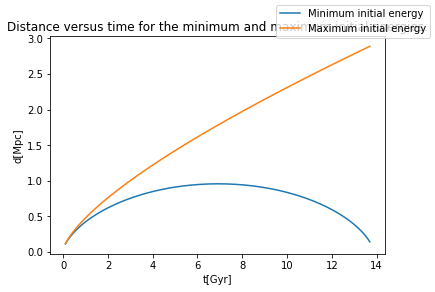

In [214]:
fig,axs = plt.subplots()
axs.plot(s_to_Gyr(np.array(t_min)),m_to_Mpc(np.array(d_min)), label= "Minimum initial energy")
axs.plot(s_to_Gyr(np.array(t_max)),m_to_Mpc(np.array(d_max)),  label= "Maximum initial energy")
fig.legend()
axs.set_xlabel("t[Gyr]")
axs.set_ylabel("d[Mpc]")
axs.set_title("Distance versus time for the minimum and maximum initial energies.")

## Animations

In [ ]:
"""
particle = Particle()

# Set up figure and 2D axis for animation
fig, ax = plt.subplots()
ax.set_xlim([-4e6 * const.pc.value, 4e6 * const.pc.value])
ax.set_ylim([-4e6 * const.pc.value, 4e6 * const.pc.value])

# Initialize the particle plot
point, = ax.plot([], [], 'bo', markersize=5)  # Particle as a blue dot
central_mass, = ax.plot([0], [0], 'ro', markersize=1)  # Central mass (stationary at the origin)

# Update function for animation
def update(frame):
    particle.update_brute()  # Update particle's position and velocity
    
    # Print particle's current position for debugging
    #print(f"Frame {frame}: Position: {particle.r}, Velocity: {particle.v}")
    
    # Update the particle's 2D position
    point.set_data(particle.r[0], particle.r[1])  # Update (x, y) data
    
    # Redraw the figure canvas
    fig.canvas.draw()
    
    return point, central_mass

# Create the animation
ani = FuncAnimation(fig, update, frames=500, interval=30, blit=True)

plt.show()
    

particle = Particle()

# Set up figure and 3D axis for animation
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_xlim([-4e6 * const.pc.value, 4e6 * const.pc.value])
ax.set_ylim([-4e6 * const.pc.value, 4e6 * const.pc.value])
ax.set_zlim([-4e6 * const.pc.value, 4e6 * const.pc.value])

# Initialize the particle plot
point, = ax.plot([particle.r[0]], [particle.r[1]], [particle.r[2]], 'bo', markersize=5)  # Particle
central_mass, = ax.plot([0], [0], [0], 'ro', markersize=1)  # Central mass (stationary at the origin)

# Update function for animation
def update(frame):
    particle.update_brute()  # Update particle's position and velocity
    point.set_data(particle.r[0], particle.r[1])
    point.set_3d_properties(particle.r[2])
    return point, central_mass

#for i in range(10000):
    #update(i)
# Create the animation
ani = FuncAnimation(fig, update, frames=500, interval=30)
#ani.save('particle_animation.gif', writer='imagemagick')

plt.show()
"""